<a href="https://colab.research.google.com/github/dawidstajszczyk/thesis_APO/blob/main/image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ekstrakcja danych ze strony: https://www.kaggle.com/datasets/dawidstajszczyk00/dice-r0ll

In [1]:
import zipfile
import os
from google.colab import drive

# Montuj Google Drive
drive.mount('/content/drive')

# Skopiuj plik kaggle.json do środowiska Colab
!cp '/content/drive/MyDrive/kaggle/kaggle.json' '/content'
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Pobierz zestaw danych
!kaggle datasets download -d dawidstajszczyk00/dice-r0ll

# Ścieżka do katalogu, gdzie znajduje się pobrany plik ZIP
zip_file_path = '/content/dice-r0ll.zip'

# Katalog docelowy dla rozpakowwanych danych
extracted_folder_path = '/content/extracted_images'

# Rozpakuj plik ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

Mounted at /content/drive
 99% 180M/182M [00:02<00:00, 116MB/s] 
100% 182M/182M [00:02<00:00, 90.3MB/s]


Wyodrębnienie losowych próbek do zbioru testowego

In [2]:
from sklearn.model_selection import train_test_split
import os
import random

# Ścieżka do foldera zawierającego klasy
base_path = '/content/extracted_images/dataset/'

# Lista klas
classes = ['1', '2', '3', '4', '5', '6']

# Lista zawierająca pełne ścieżki do folderów klas
class_paths = [os.path.join(base_path, class_name) for class_name in classes]

# Ścieżka do foldera testowego
test_path = os.path.join(extracted_folder_path, "test")

# Utwórz folder testowy, jeśli nie istnieje
os.makedirs(test_path, exist_ok=True)


# Podział każdego folderu klasy na zbiór treningowy i testowy
for class_path in class_paths:
    images = os.listdir(class_path)

    _, test_images = train_test_split(images, test_size=0.02, random_state=42)

    # Przenieś odpowiednie obrazy do folderu testowego
    for test_image in test_images:
        src_path = os.path.join(class_path, test_image)
        dest_path = os.path.join(test_path, test_image)
        os.rename(src_path, dest_path)

# Po dodaniu obrazów do zbioru testowego, wymieszaj je
test_images = os.listdir(test_path)
random.shuffle(test_images)

Przetwarzanie obrazów - ciało funkcji

In [6]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def count_black_dots(image_path):
    # Wczytanie obrazu
    image = cv2.imread(image_path)

    # Przekształcenie obrazu na odcienie szarości
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Rozmycie Gaussowskie w celu wygładzenia krawędzi
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Binaryzacja obrazu (czarne kropki będą miały wartość 0)
    _, binary = cv2.threshold(gray, 40, 255, cv2.THRESH_BINARY)

    # Detekcja krawędzi w obrazie
    edges = cv2.Canny(binary, 50, 150)

    # Zastosowanie dylatacji w celu połączenia ewentualnych przerw w krawędziach
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)

    # Znalezienie konturów w obrazie
    cnt, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Rysowanie konturów
    cv2.drawContours(image, cnt, -1, (0, 255, 0), 2)

    # Zliczenie czarnych kropek na podstawie pola powierzchni i kolistości
    black_dot_count = 0
    for contour in cnt:
        area = cv2.contourArea(contour)
        if area < 100:  # Minimalna wielkość obszaru, aby uznać go za czarną kropkę
            continue

        # Sprawdzenie, czy kontur jest zbliżony do kształtu okręgu
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > 0.8:  # Określ próg, powyżej którego uznajemy kształt za okrągły
            black_dot_count += 1

    return dilated, black_dot_count

Przetwarzanie obrazów

In [7]:
from skimage import io, color
import shutil

# Wyczyść workspace
#folder_path = '/content/extracted_images/processed_images'
#shutil.rmtree(folder_path, ignore_errors=True)


# Ścieżka, w którym zostaną umieszczone przetworzone obrazy
processed_path = '/content/extracted_images/processed_images/'

# Utwórz folder processed_images, jeśli nie istnieje
os.makedirs(processed_path, exist_ok=True)

#test_path

image_files = os.listdir(test_path)

for image_file in image_files:
    image_path = os.path.join(test_path, image_file)

    if os.path.isfile(image_path):
        # Przetwórz obraz
        processed_image, dots_num = count_black_dots(image_path)
        cv2_imshow(processed_image)

    else:
        print("Incorrect file.")

'''
for class_label in classes:
    class_path = os.path.join(base_path, class_label)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)

        # Sprawdź, czy ścieżka prowadzi do pliku, a nie katalogu
        if os.path.isfile(image_path):
            # Wczytaj obraz
            processed_image = io.imread(image_path)

            # Przetwórz obraz
            dots_count, processed_image = count_black_dots(image_path)
            print("Liczba czarnych kropek:", dots_count)

            # Utwórz ścieżkę dla obrazu przetworzonego
            processed_image_path = os.path.join(processed_path, class_label, image_file)

            # Utwórz folder dla obrazów przetworzonych, jeśli nie istnieje
            os.makedirs(os.path.join(processed_path, class_label), exist_ok=True)

            # Zapisz przetworzony obraz w folderze processed_images
            #io.imsave(processed_image_path, (processed_image * 255).astype(np.uint8), check_contrast=False)
            io.imsave(processed_image_path, processed_image.astype(np.uint8), check_contrast=False)
        else:
          print("Incorrect file")


print("Images processed and saved to processed_images folder")

'''

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/contours.cpp:195: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


Wyodrębnienie losowych próbek do zbioru testowego

In [ ]:
from sklearn.model_selection import train_test_split
import os
import random

# Lista zawierająca pełne ścieżki do folderów klas
class_paths = [os.path.join(processed_path, class_name) for class_name in classes]

# Ścieżka do foldera testowego
test_path = os.path.join(processed_path, "test")

# Utwórz folder testowy, jeśli nie istnieje
os.makedirs(test_path, exist_ok=True)


# Podział każdego folderu klasy na zbiór treningowy i testowy
for class_path in class_paths:
    images = os.listdir(class_path)

    _, test_images = train_test_split(images, test_size=0.02, random_state=42)

    # Przenieś odpowiednie obrazy do folderu testowego
    for test_image in test_images:
        src_path = os.path.join(class_path, test_image)
        dest_path = os.path.join(test_path, test_image)
        os.rename(src_path, dest_path)

# Po dodaniu obrazów do zbioru testowego, wymieszaj je
test_images = os.listdir(test_path)
random.shuffle(test_images)

Klasyfikacja bkjbkjl

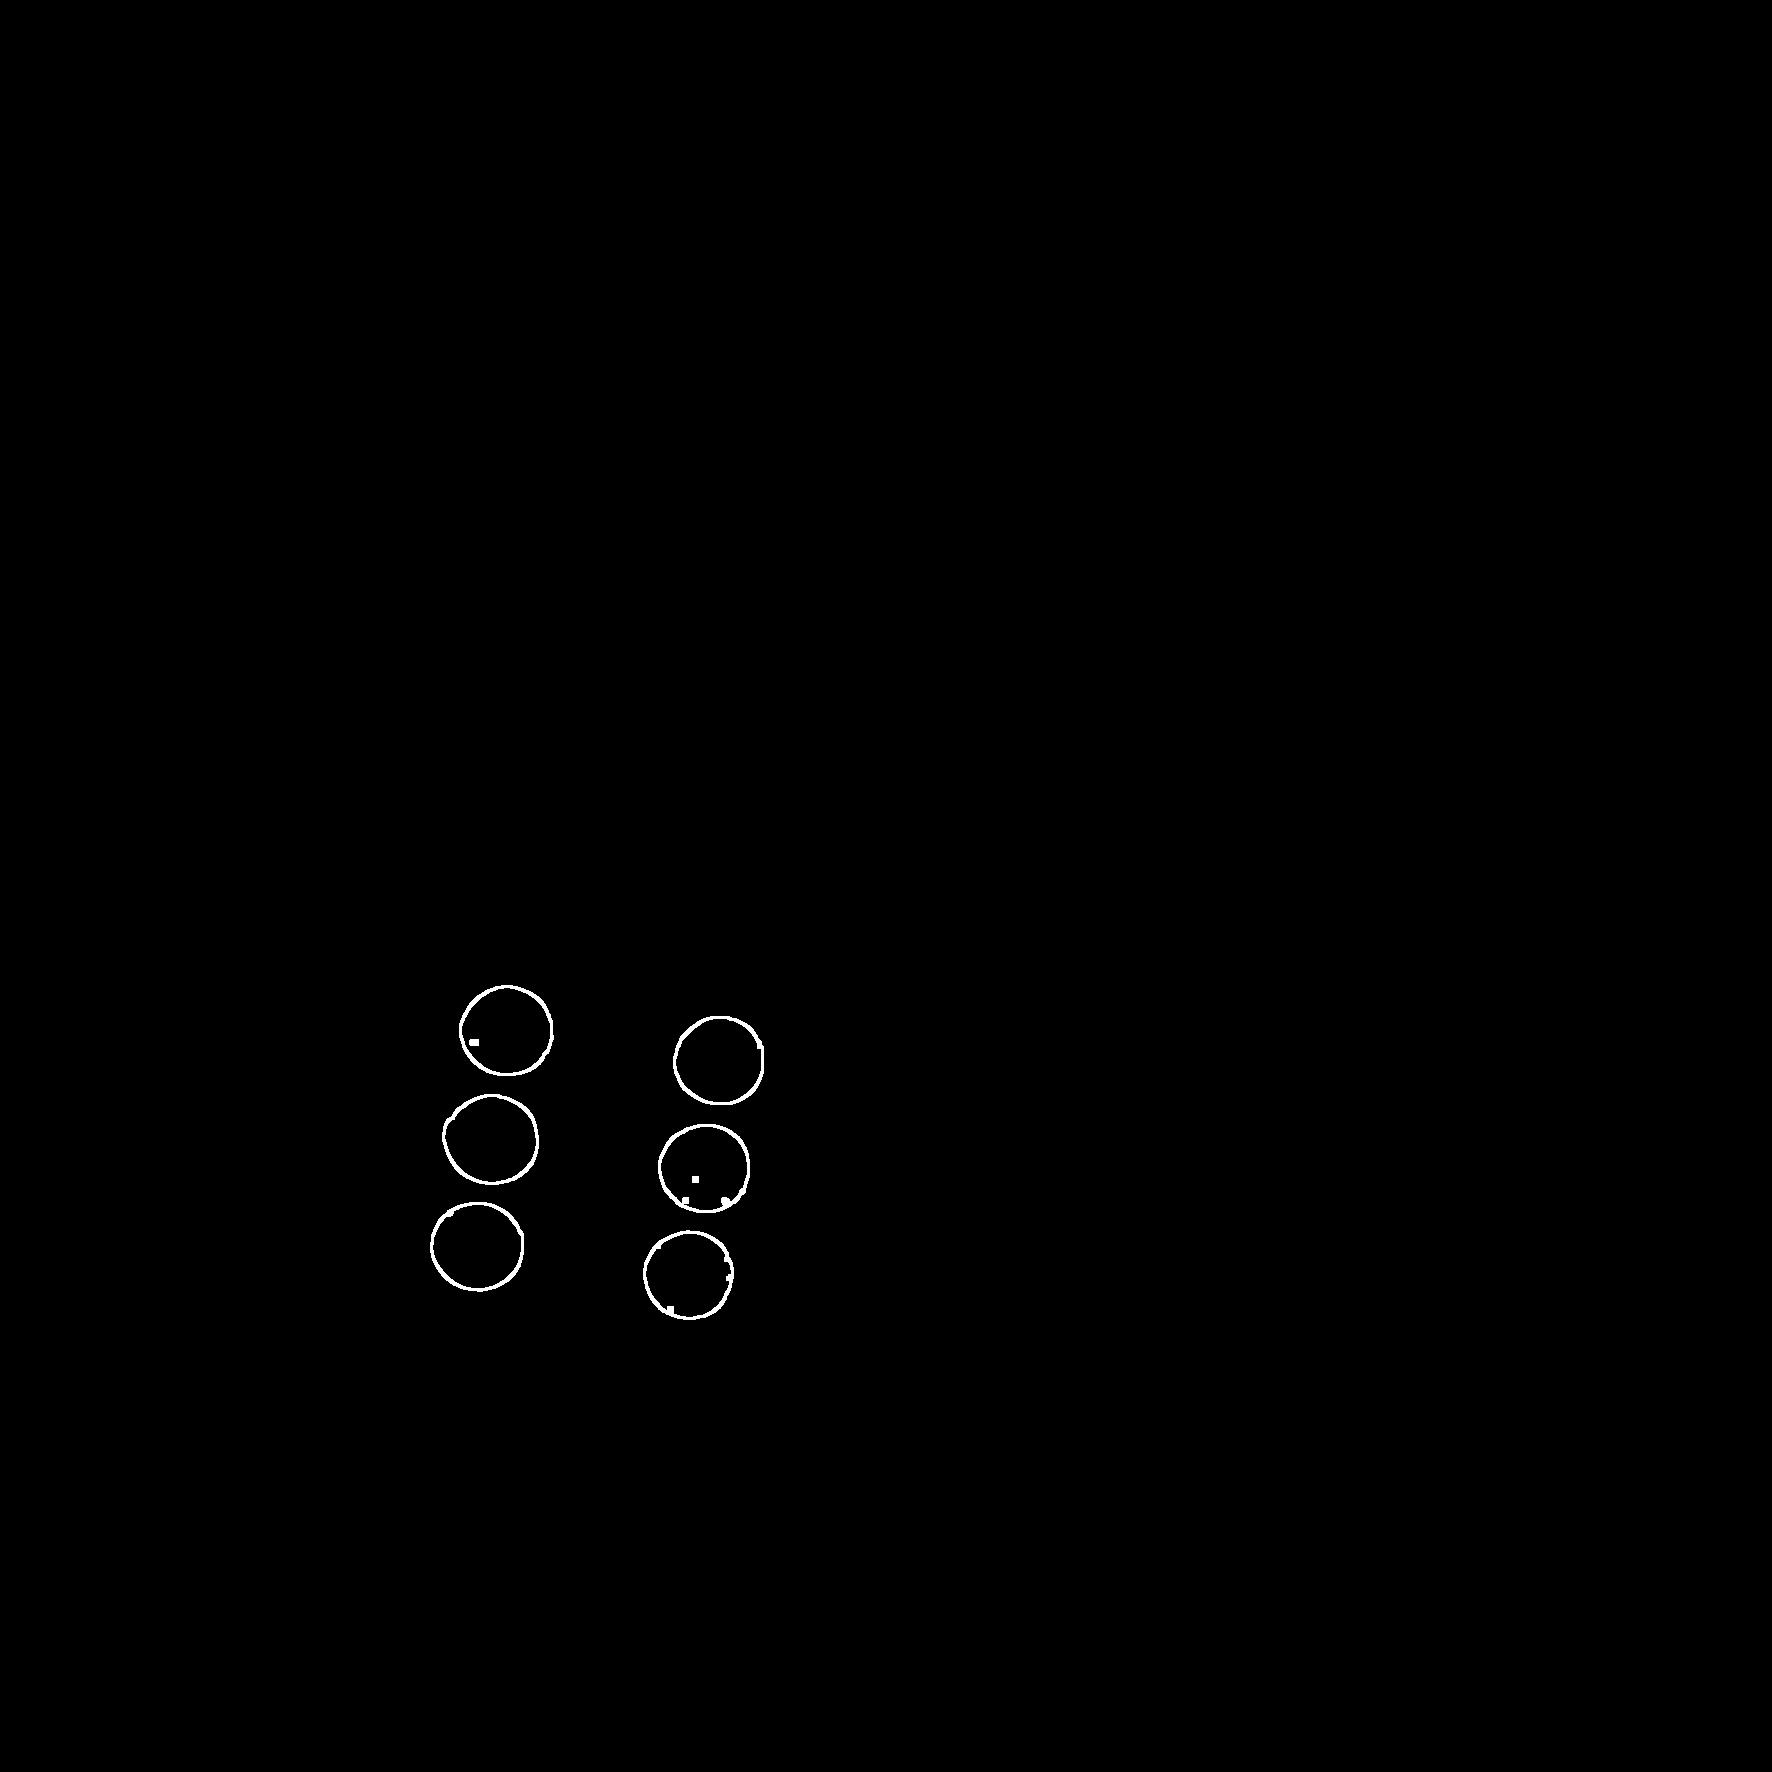

dots:  0


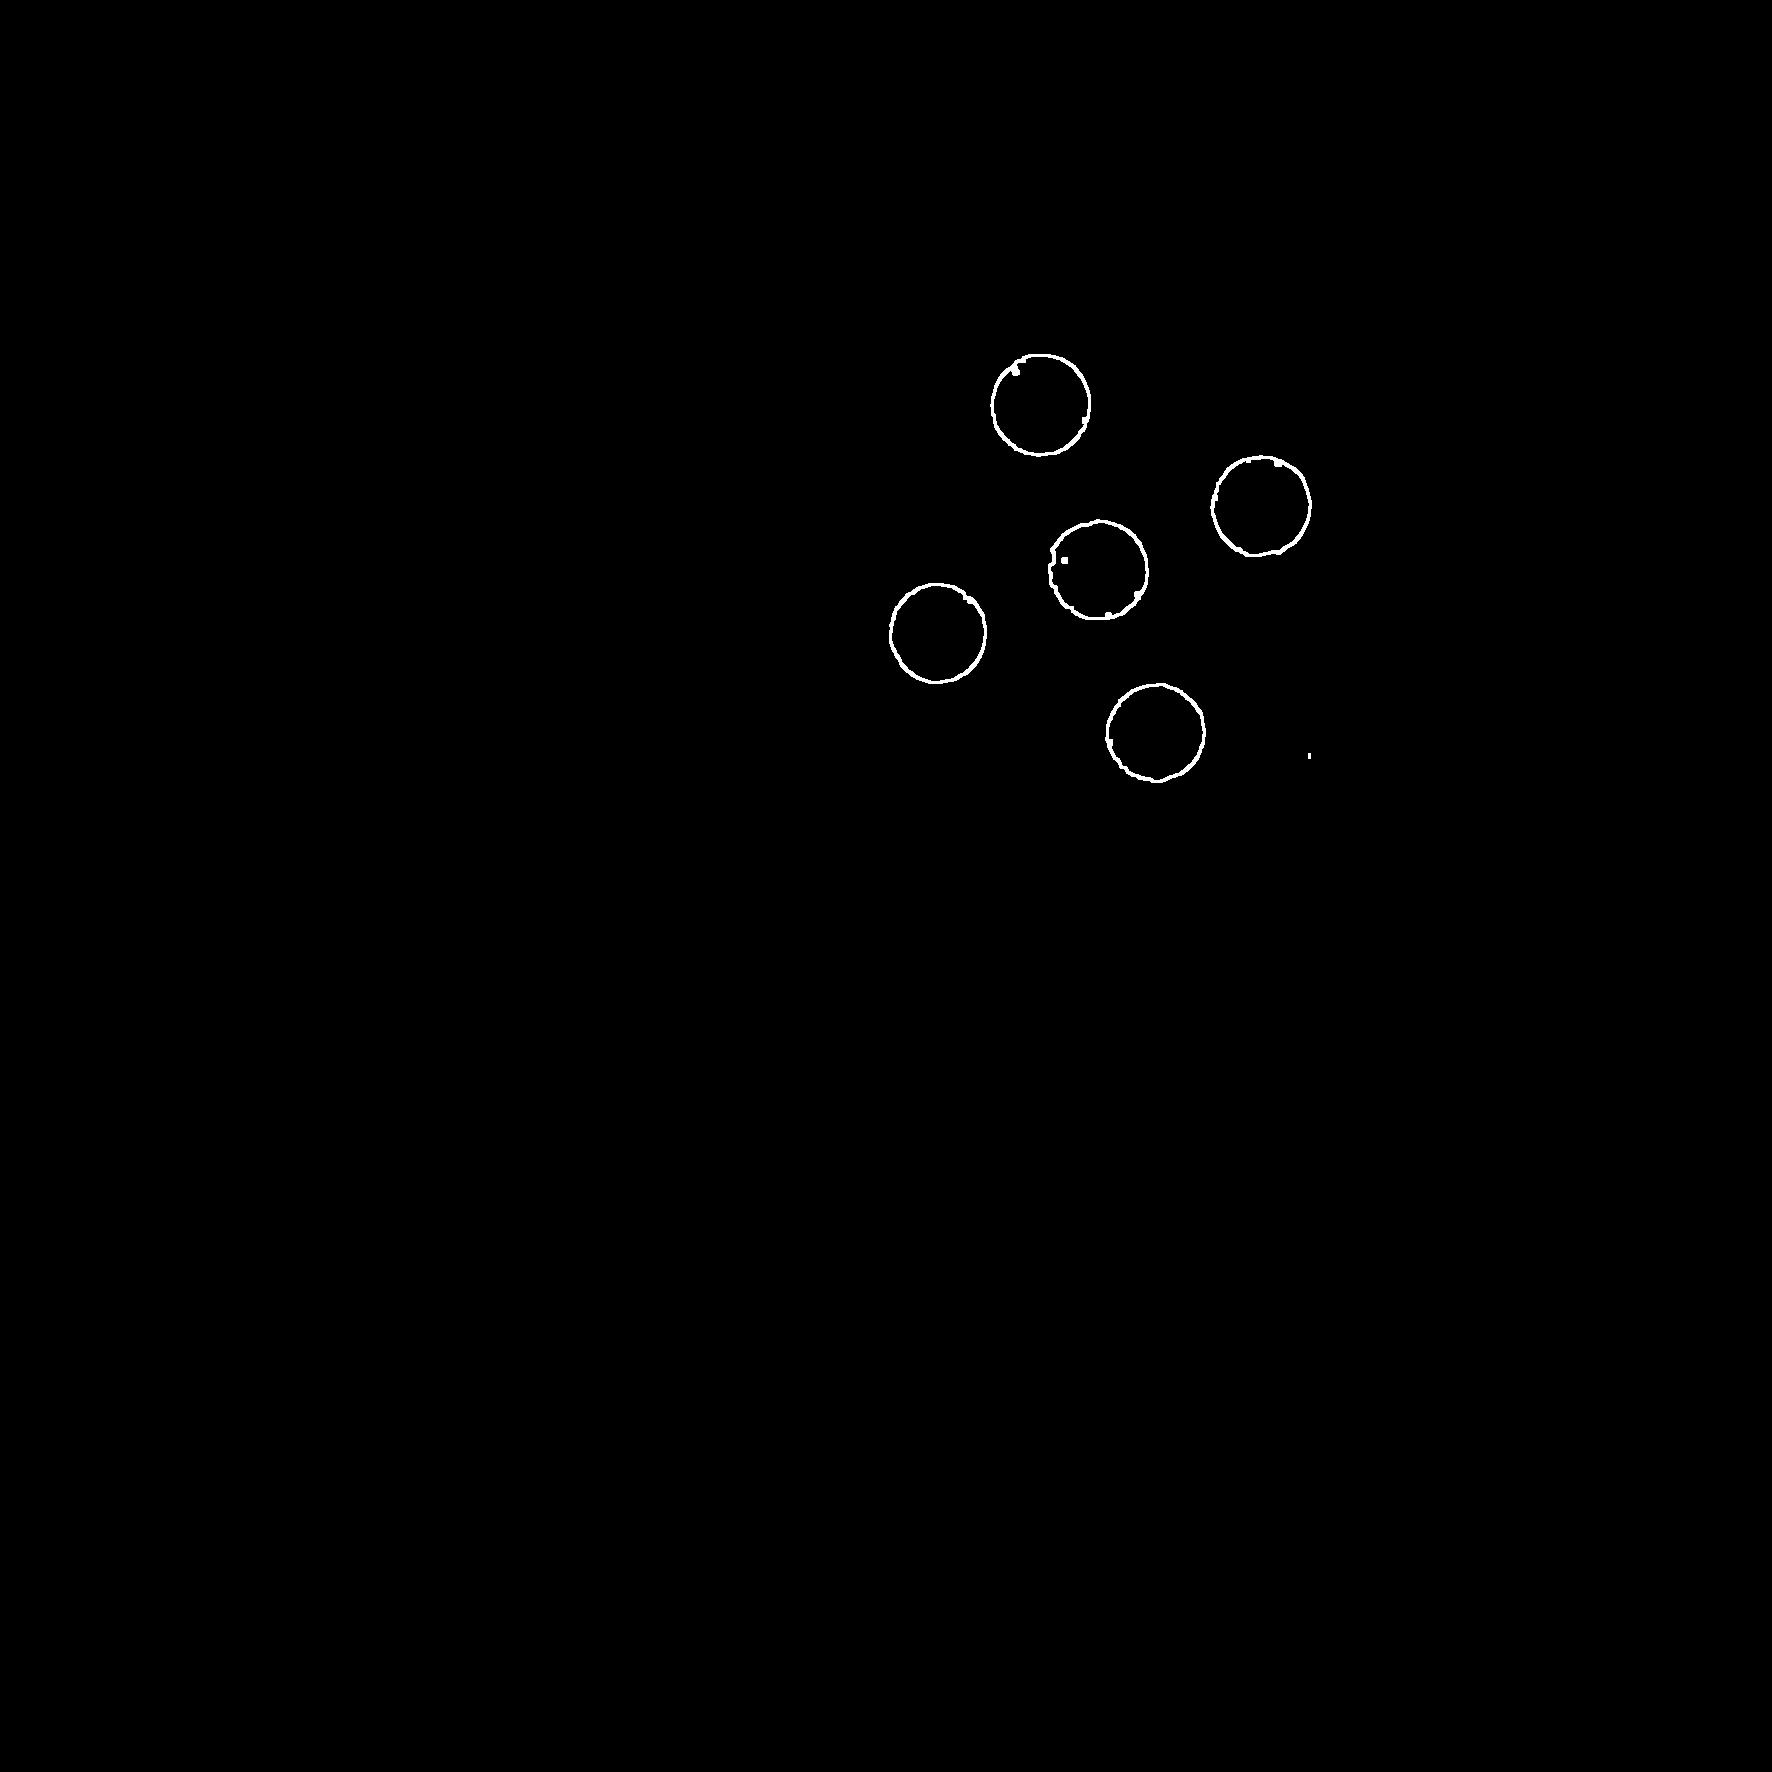

dots:  0


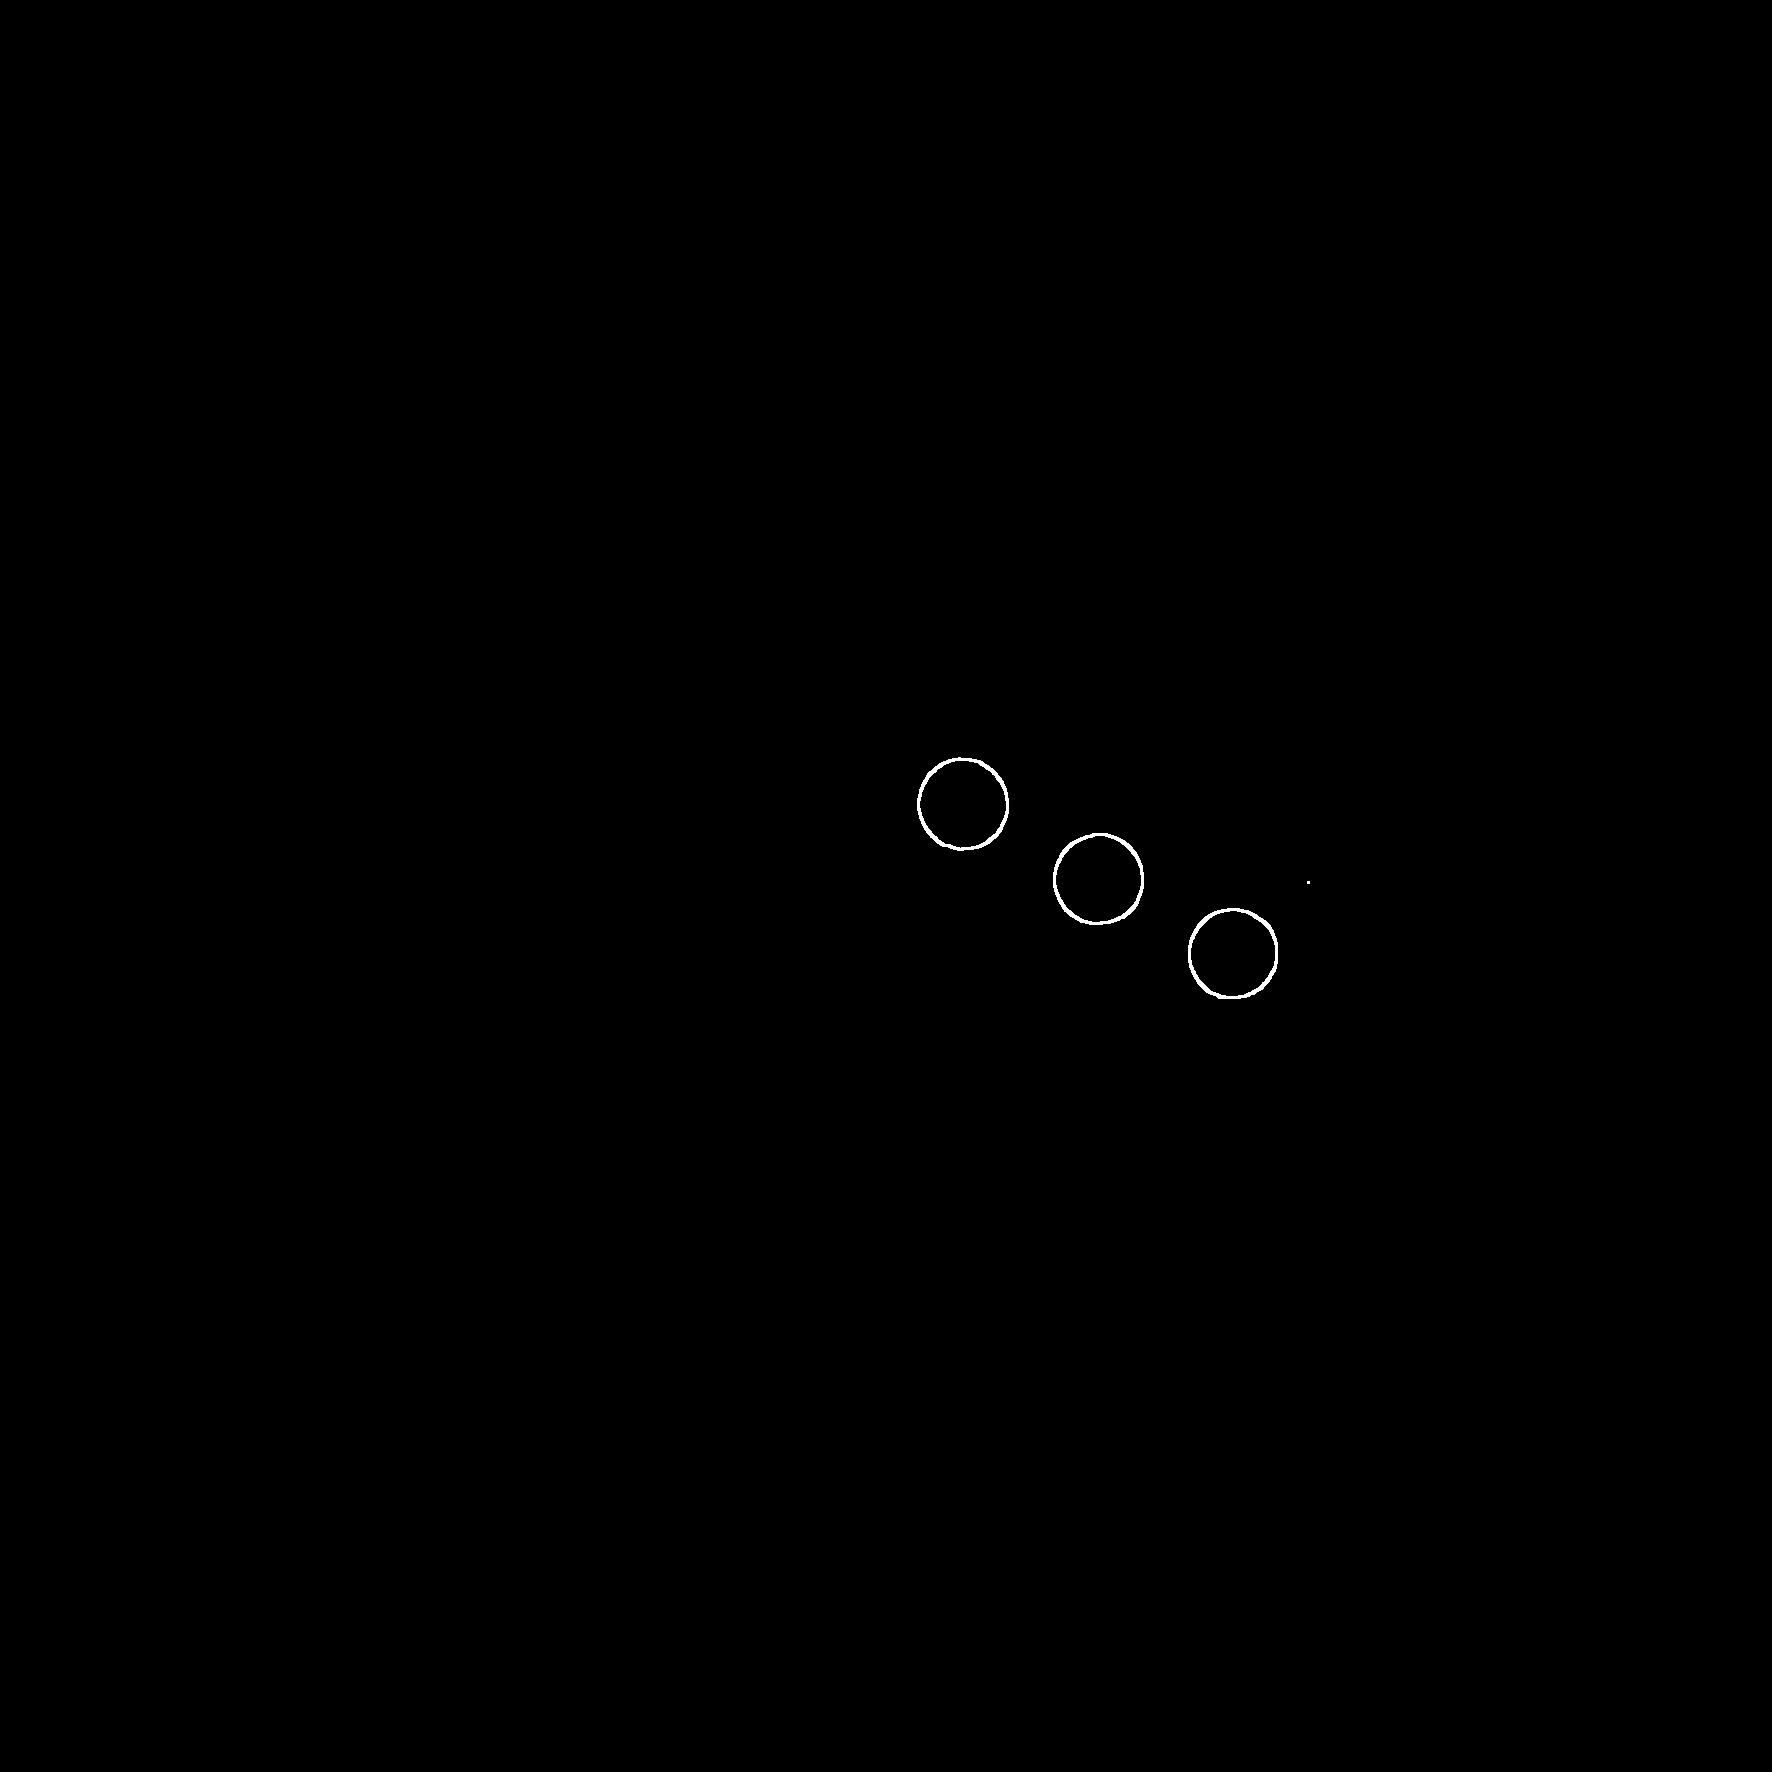

dots:  0


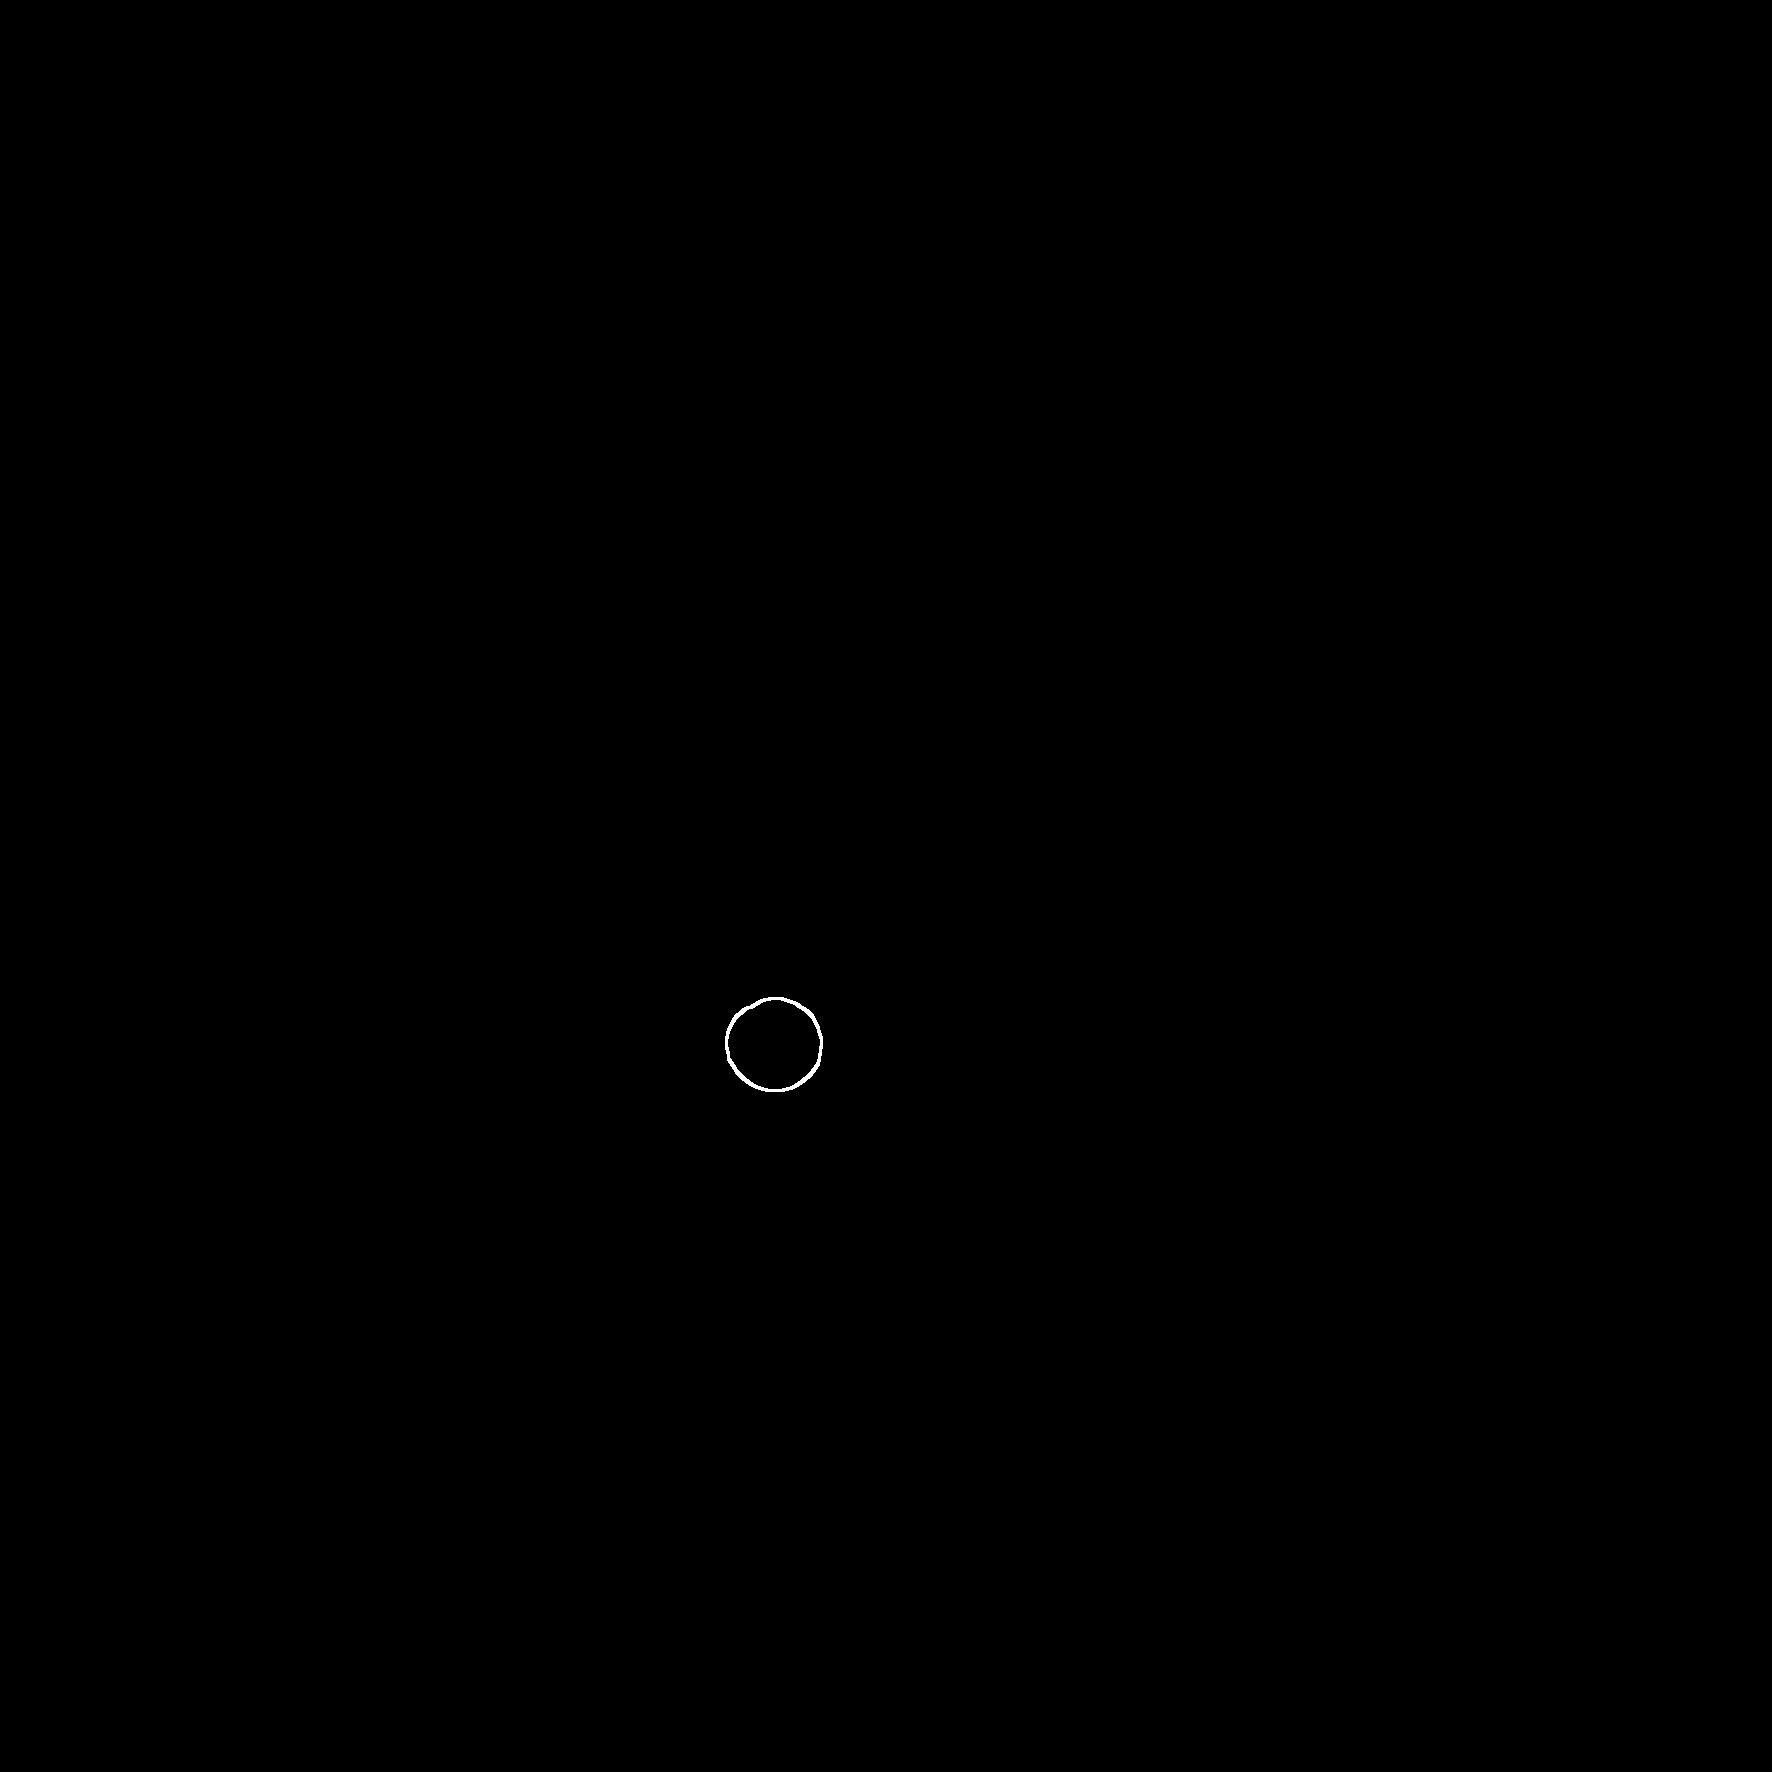

dots:  0


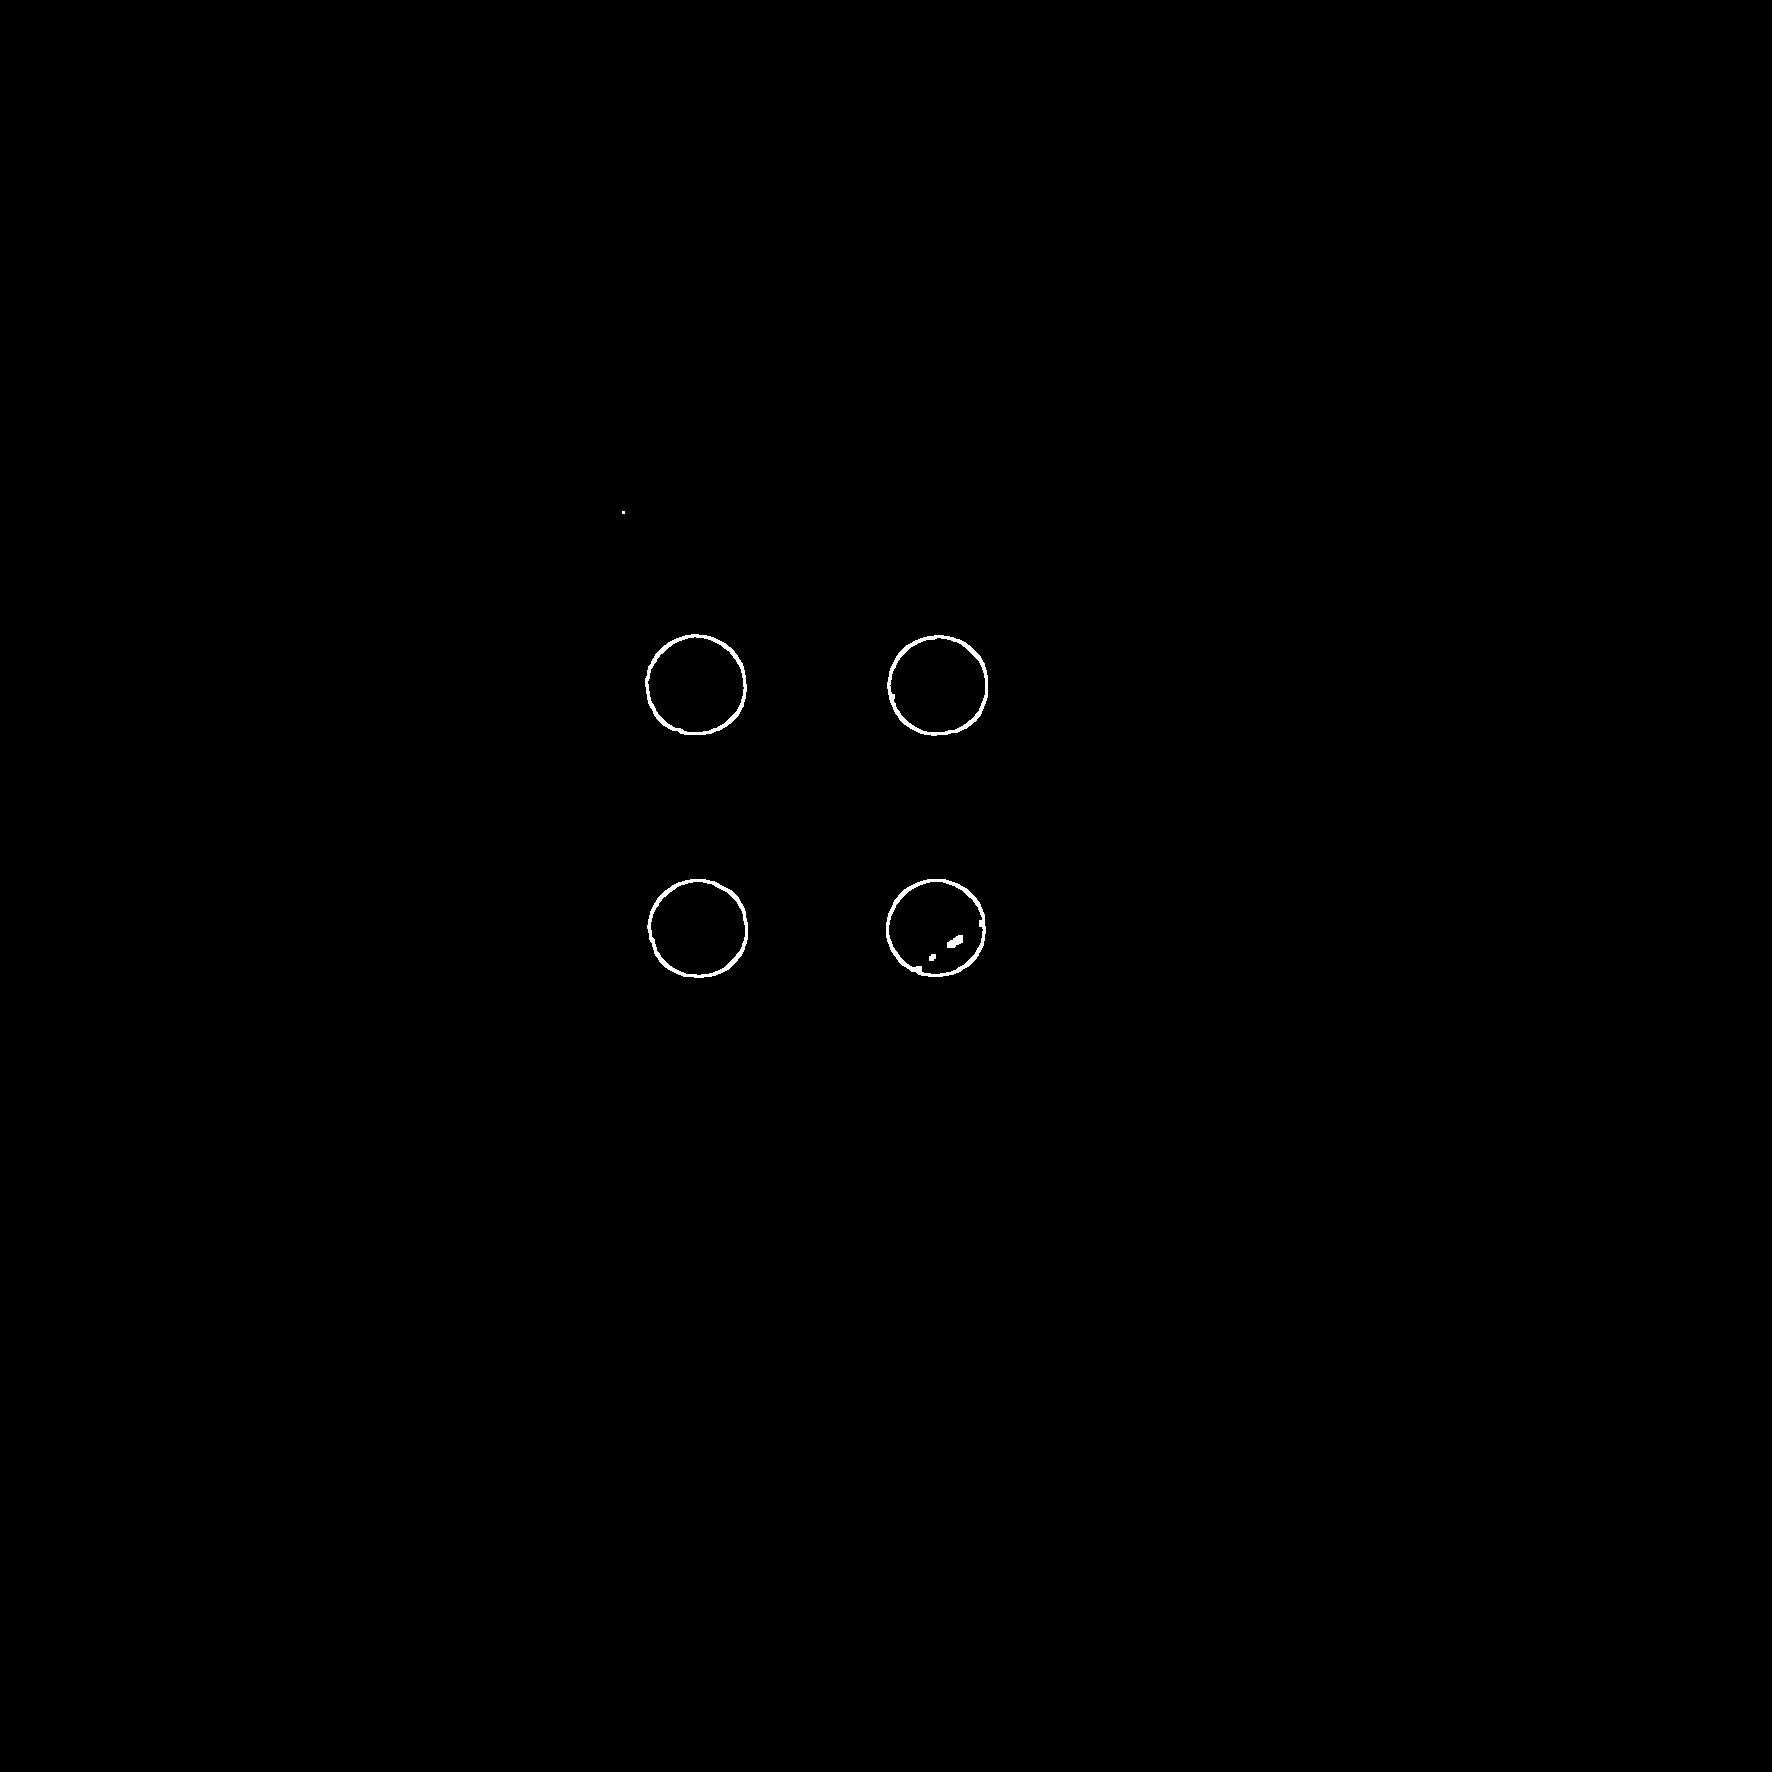

dots:  0


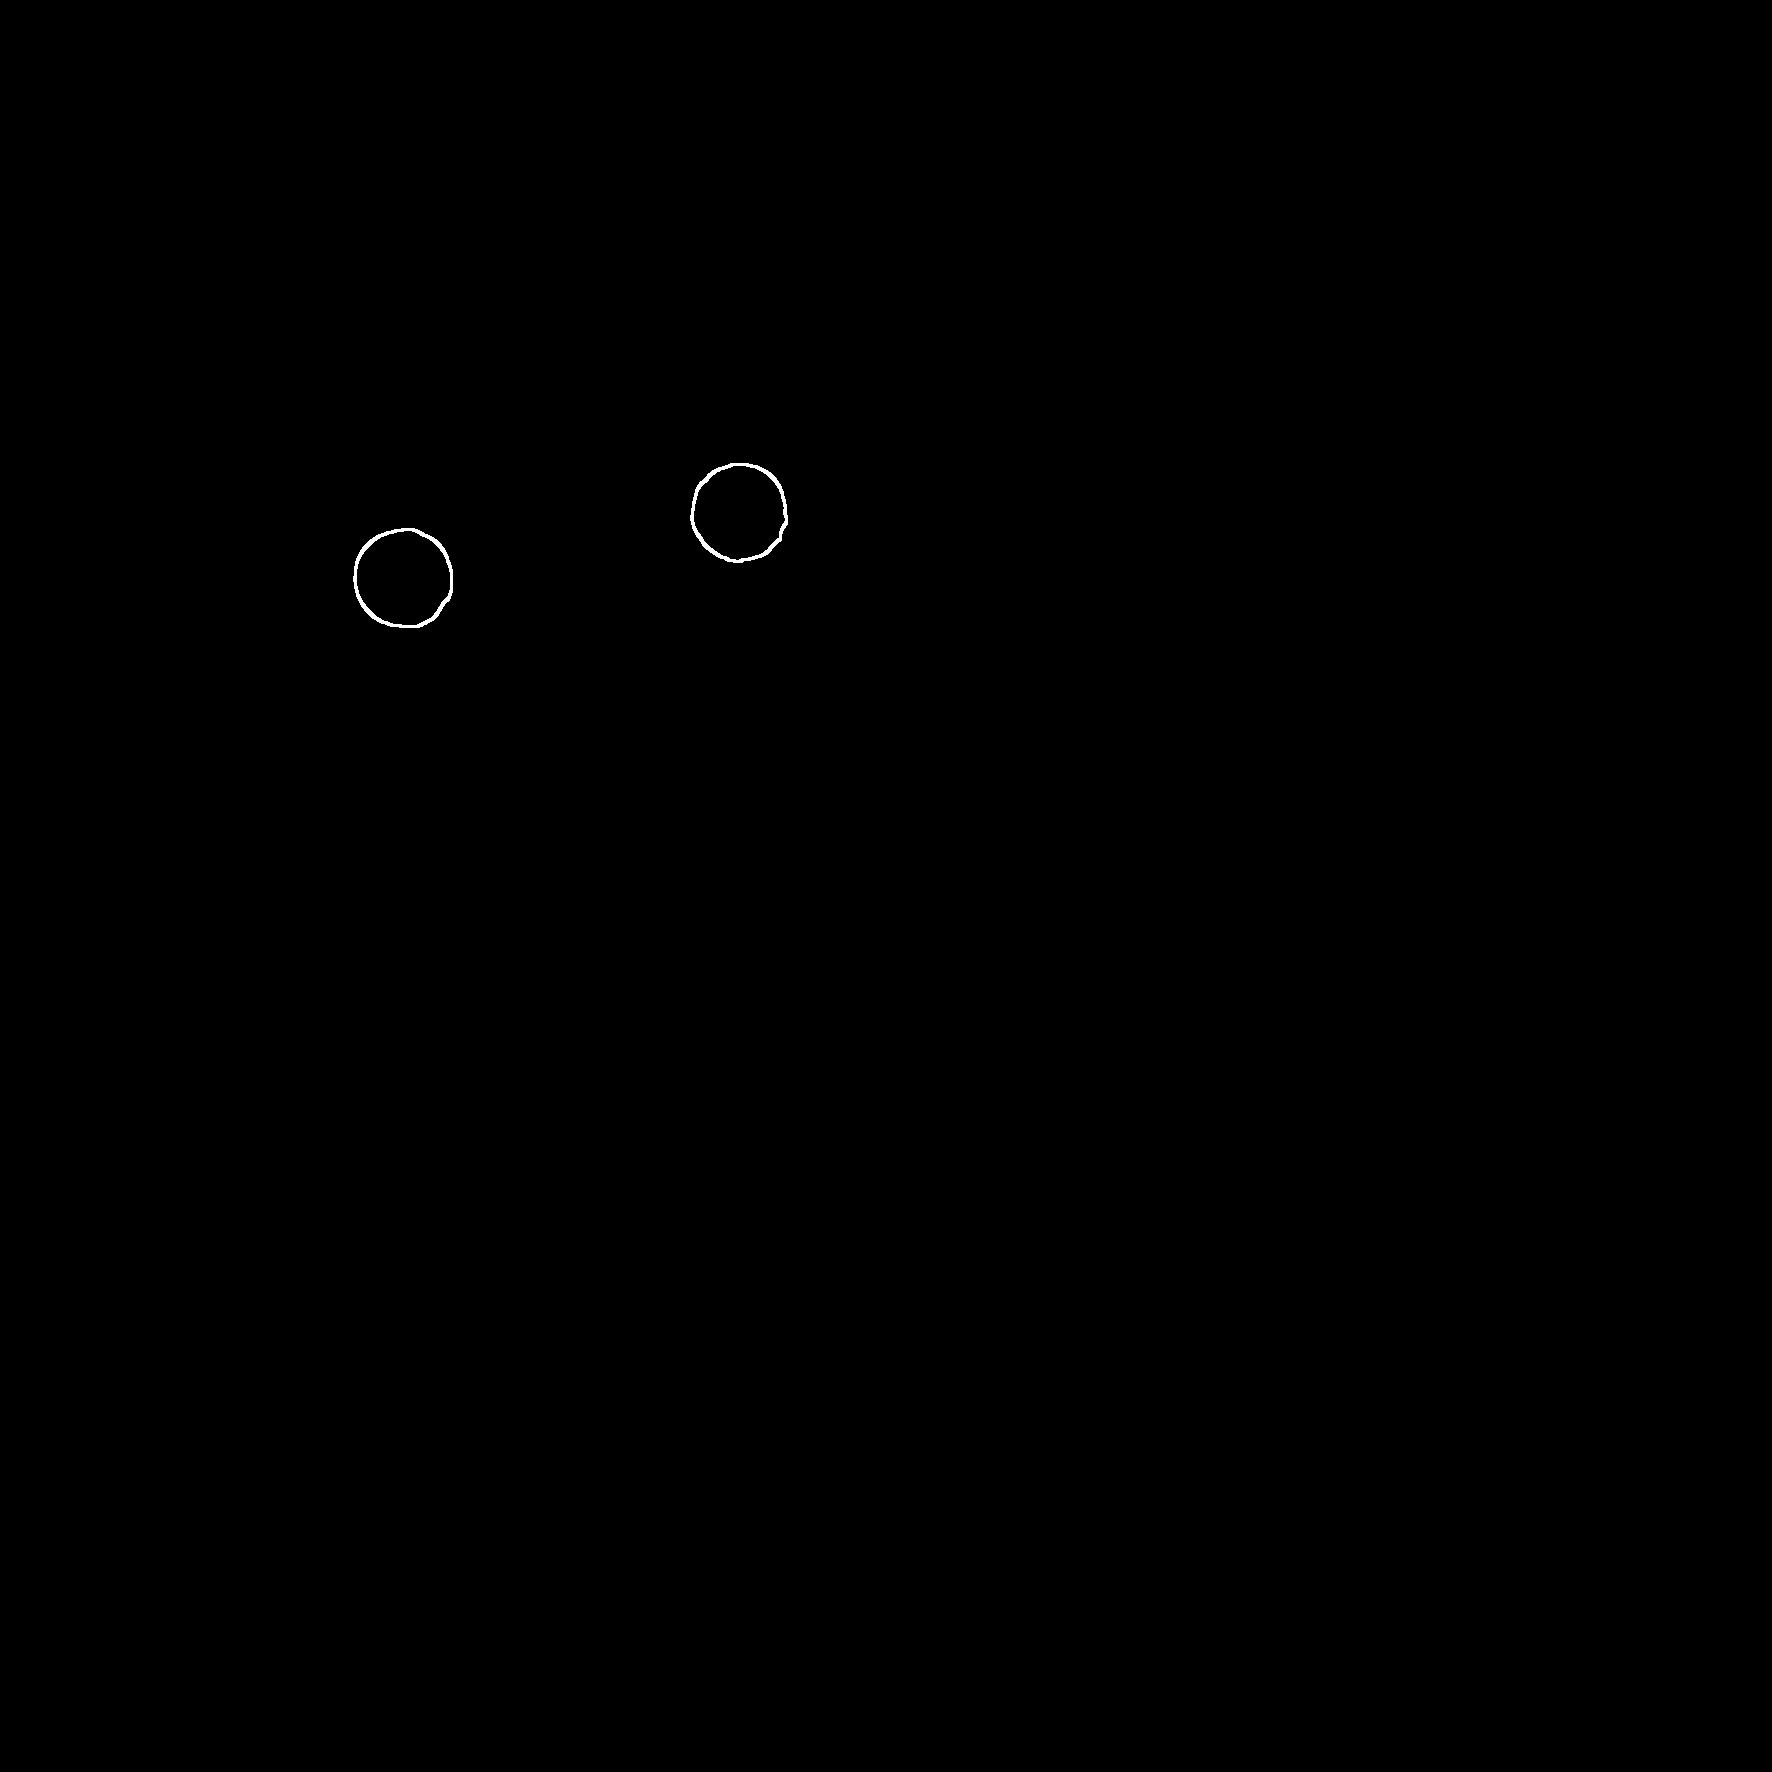

dots:  0


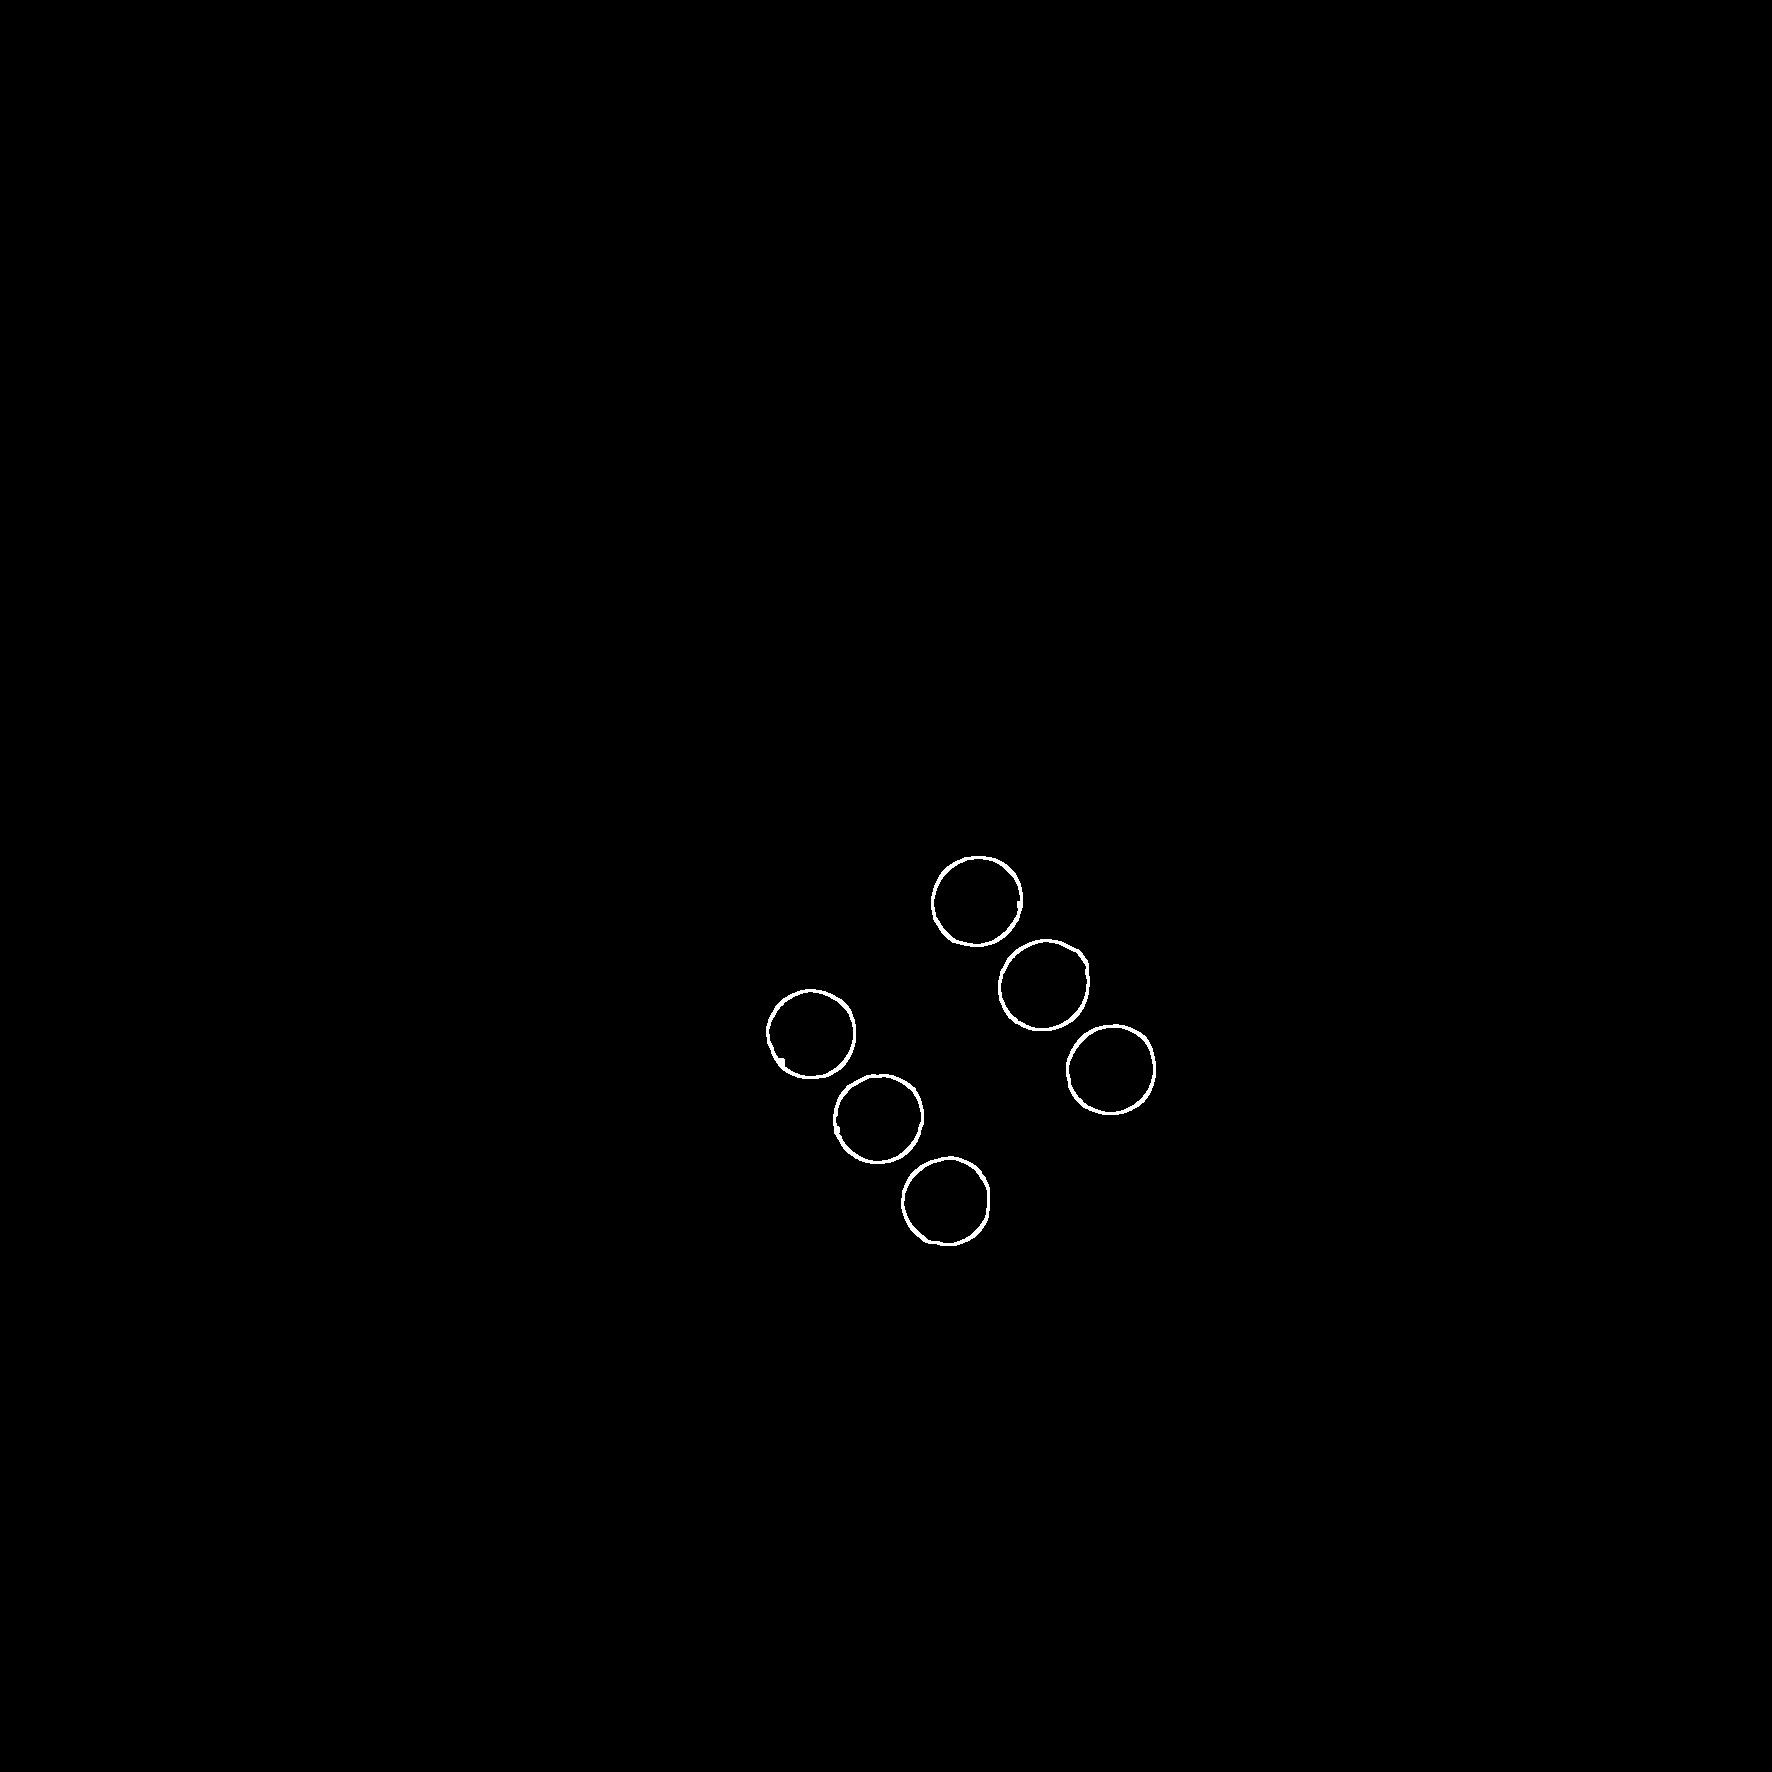

dots:  0


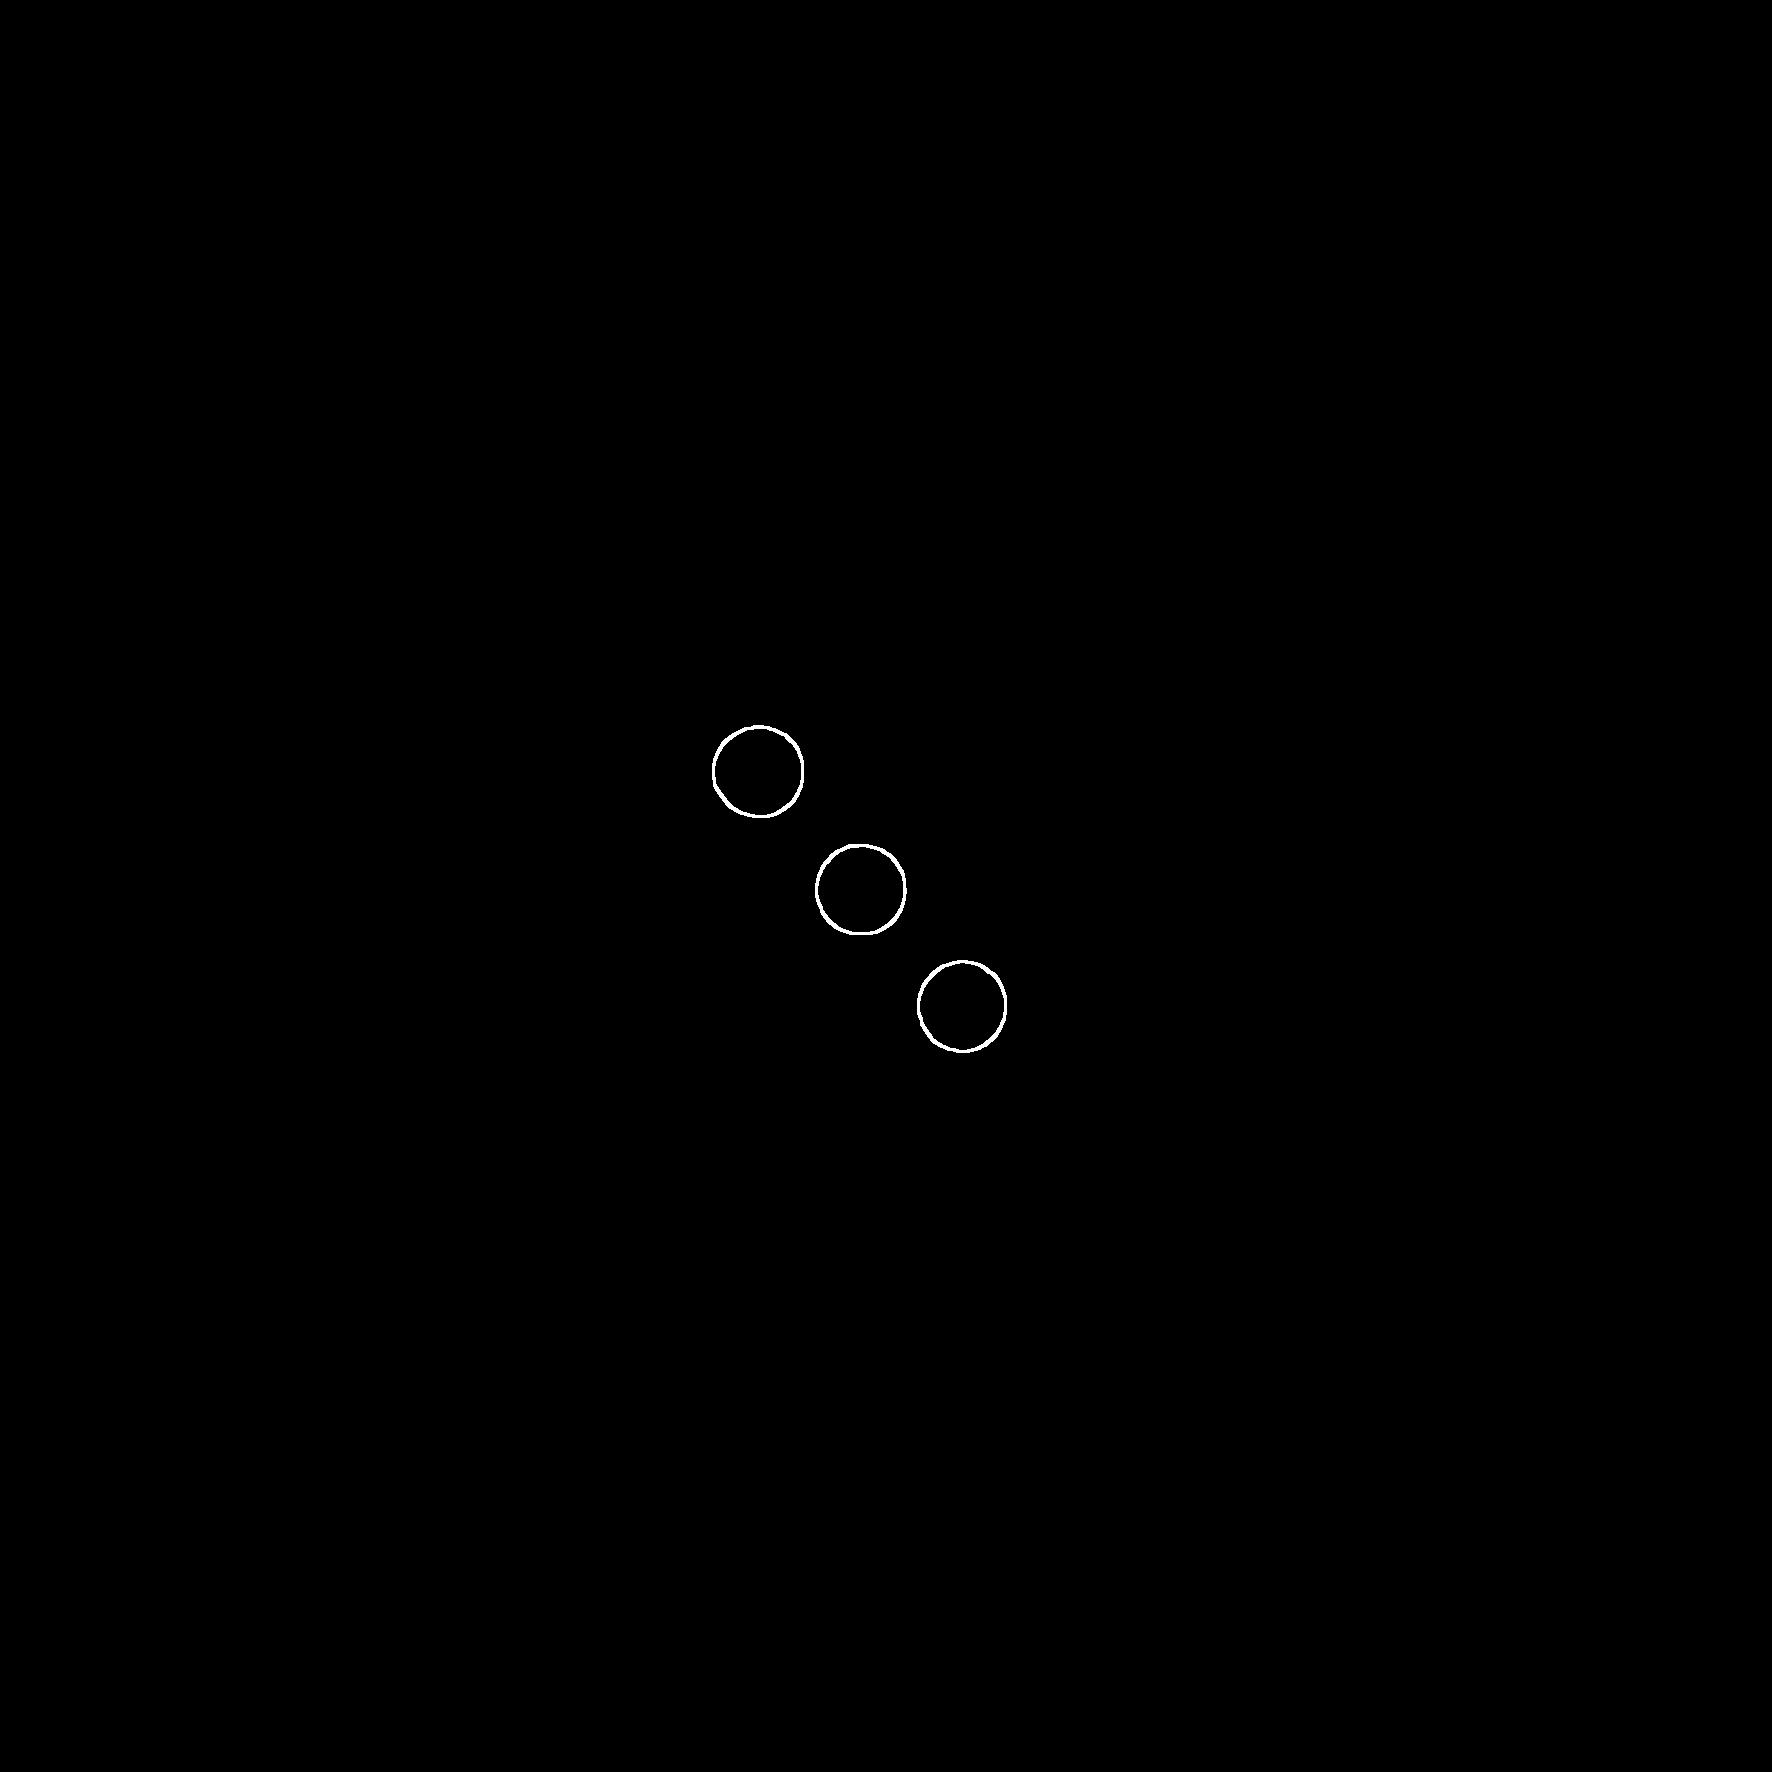

dots:  0


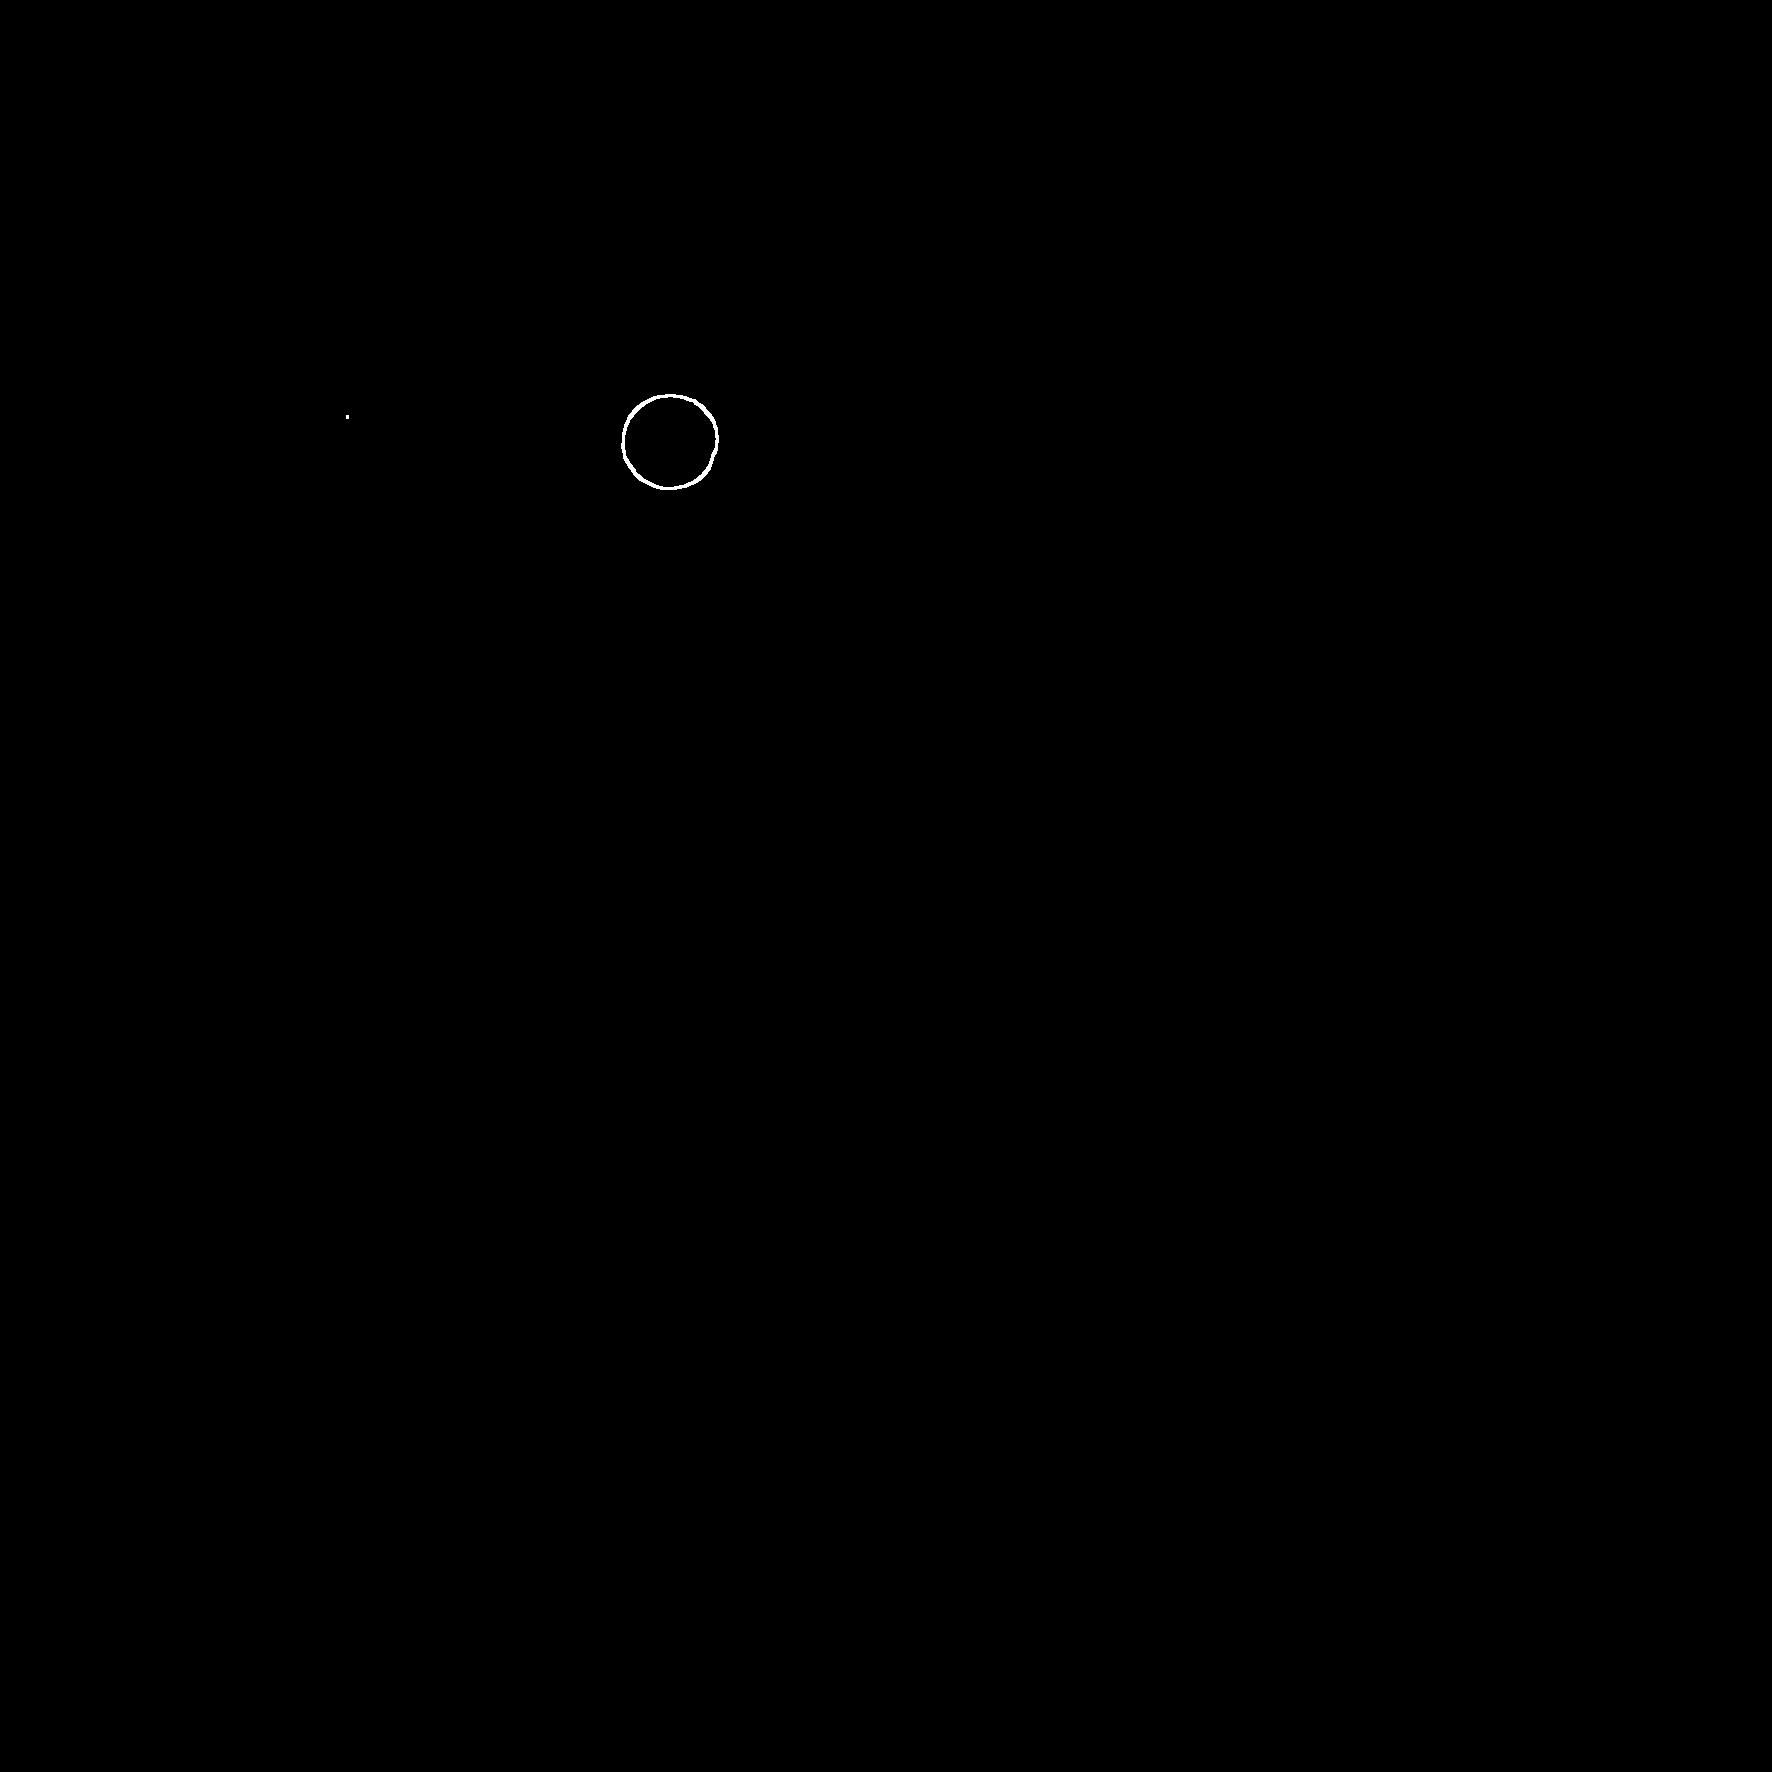

dots:  0


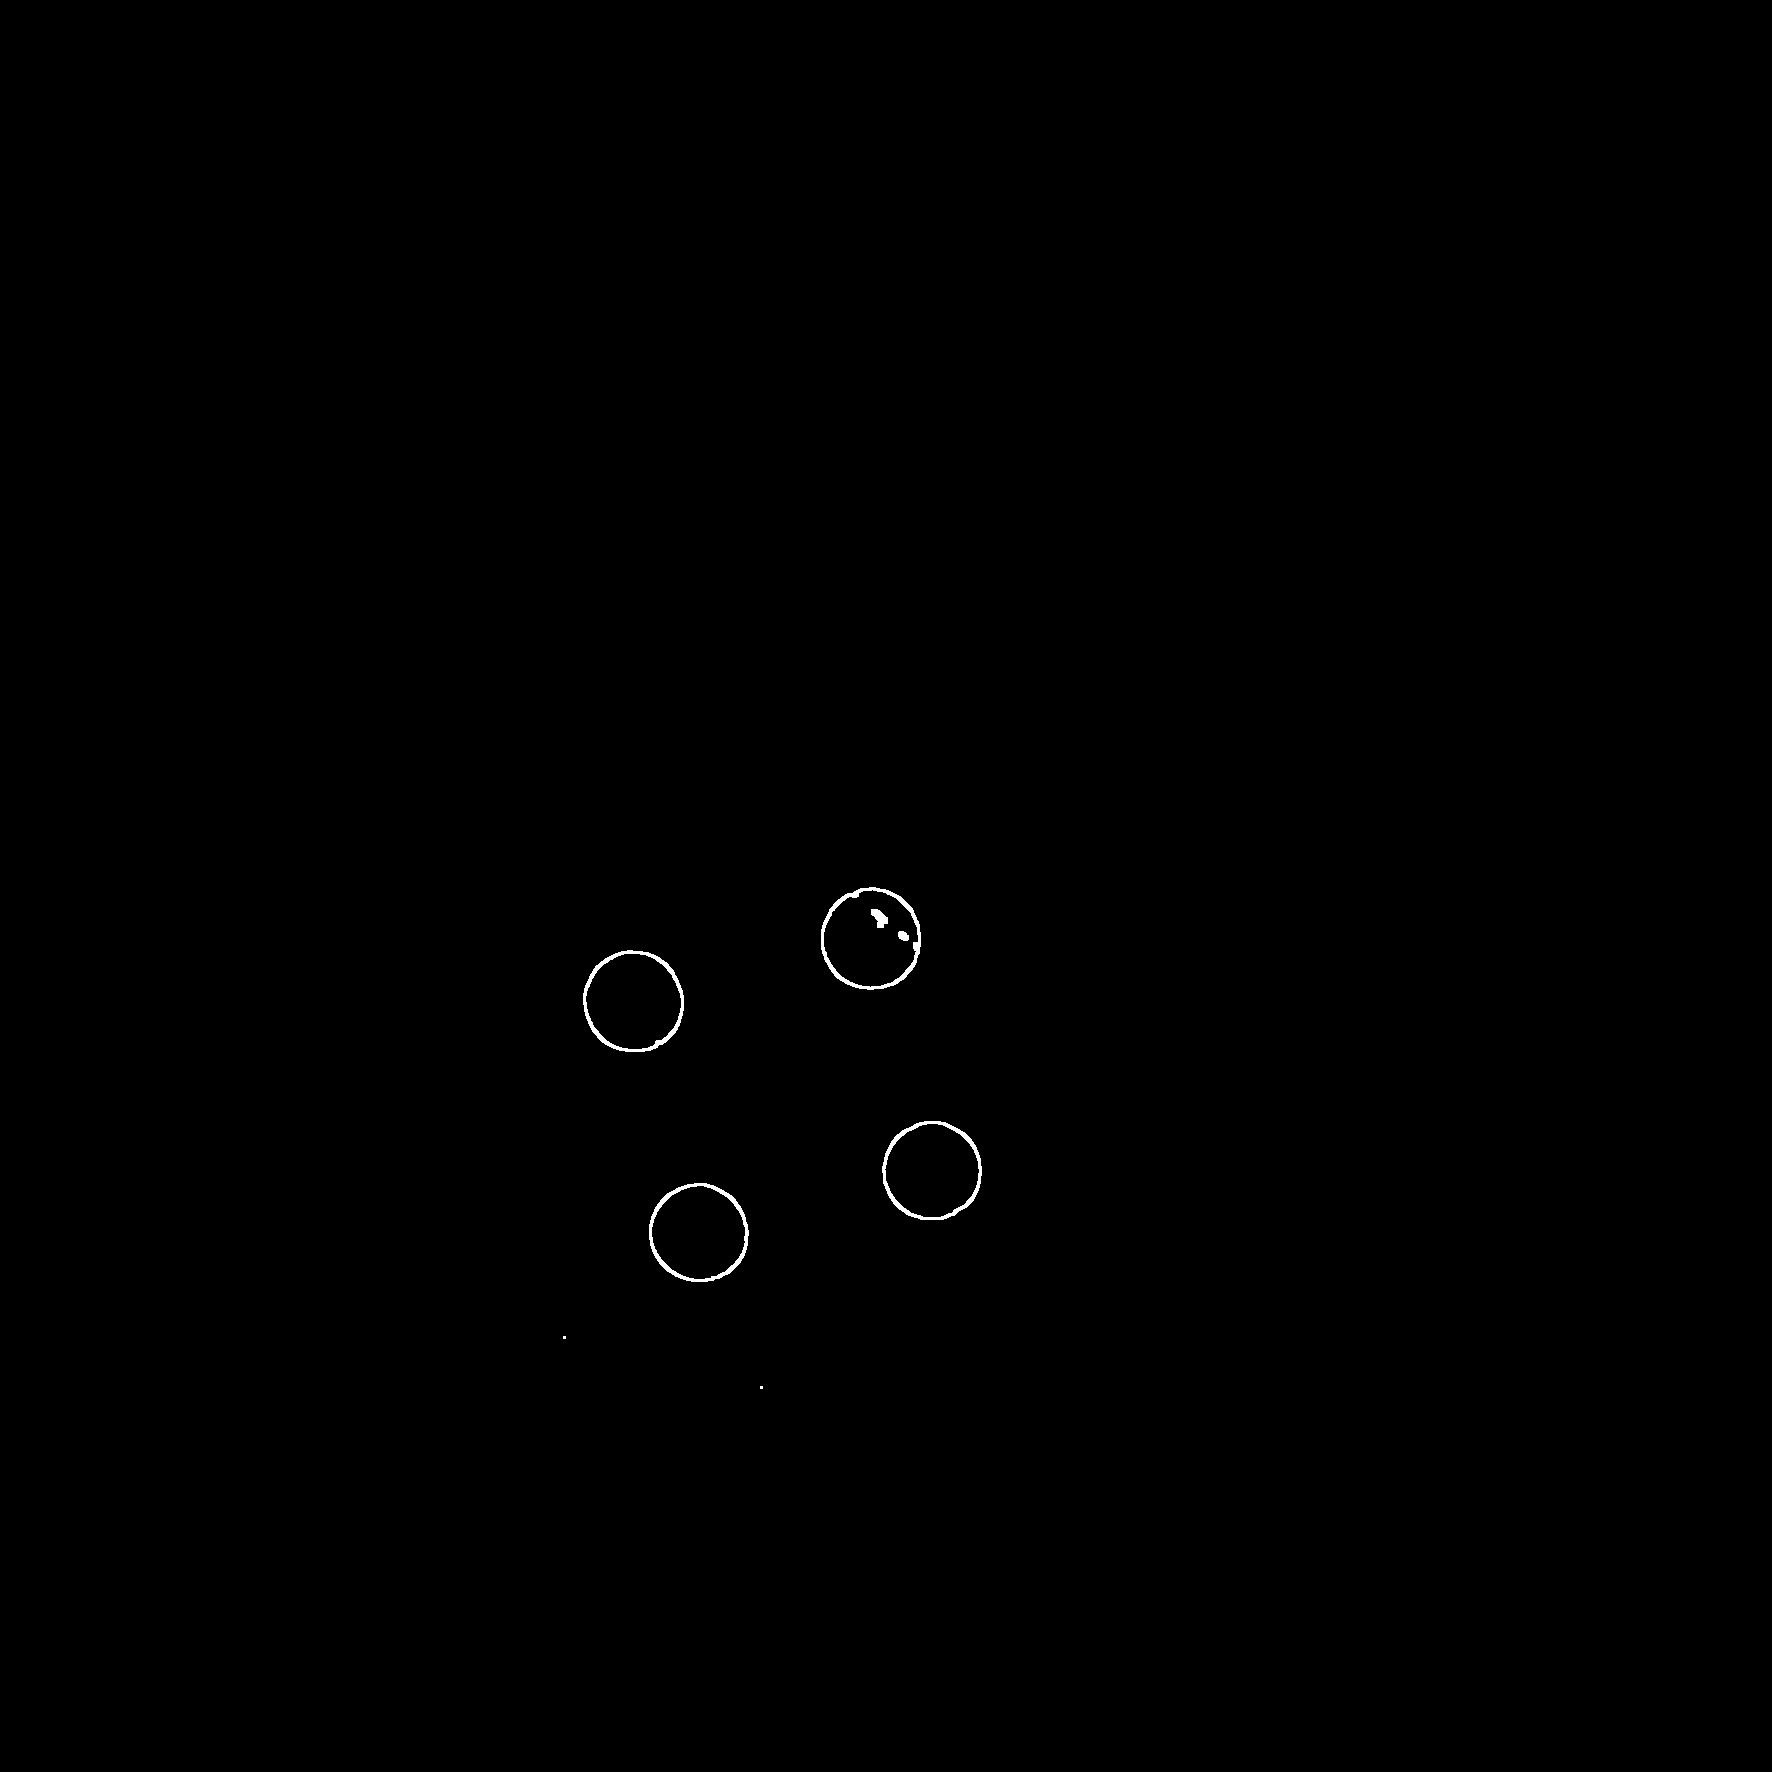

dots:  0


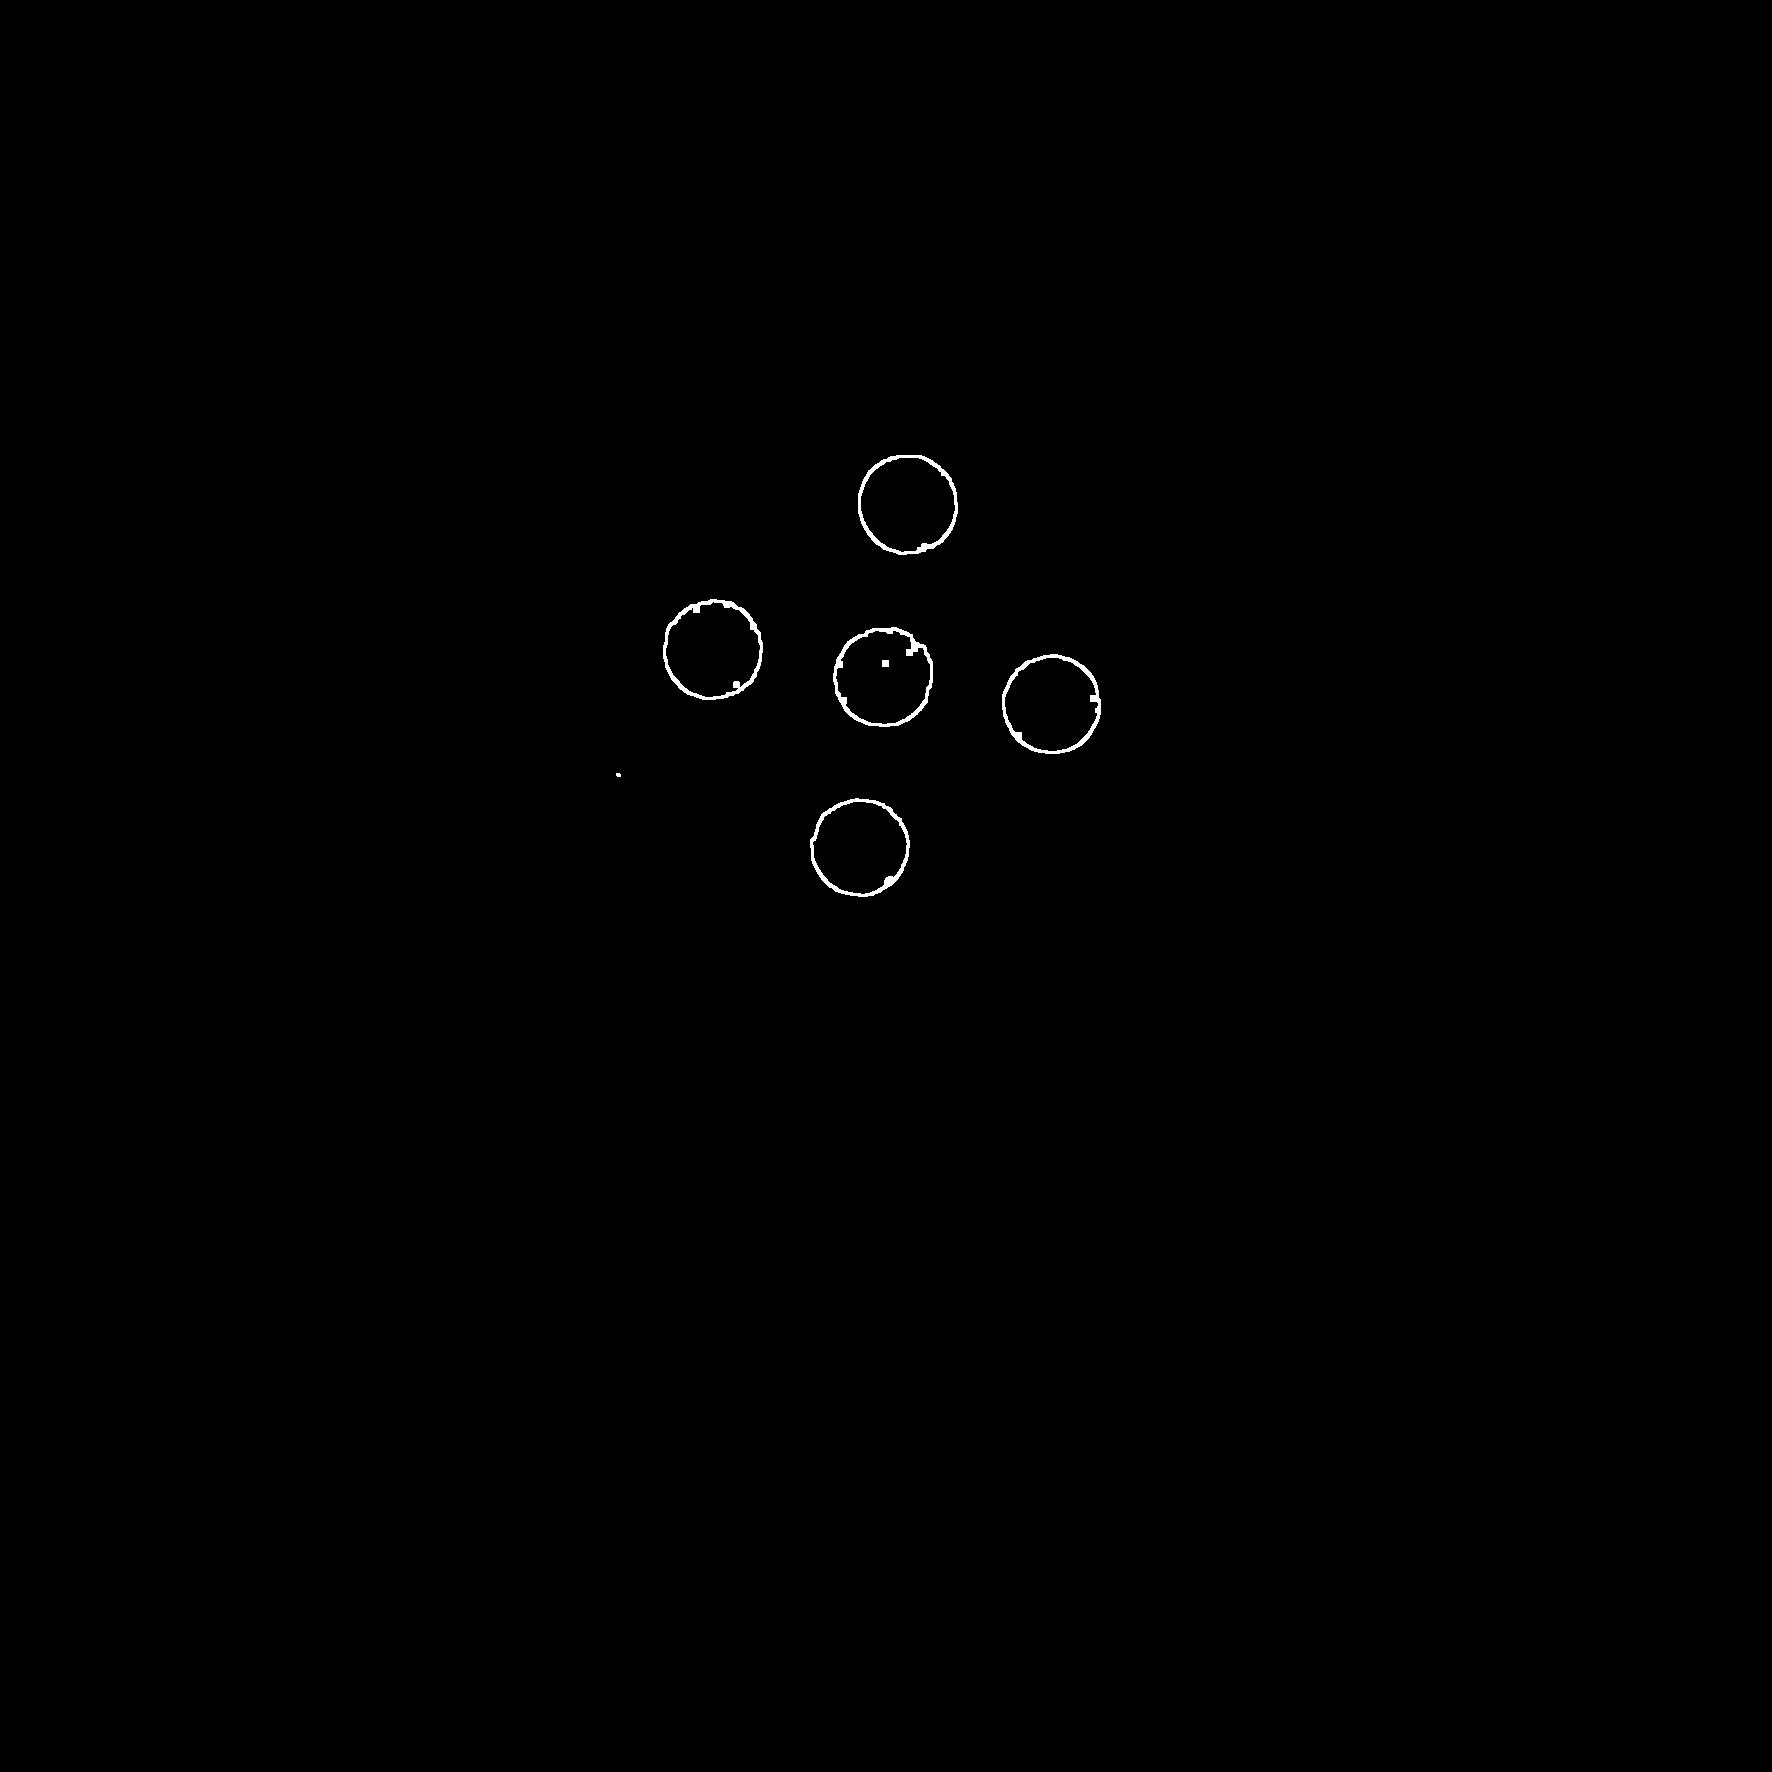

dots:  0


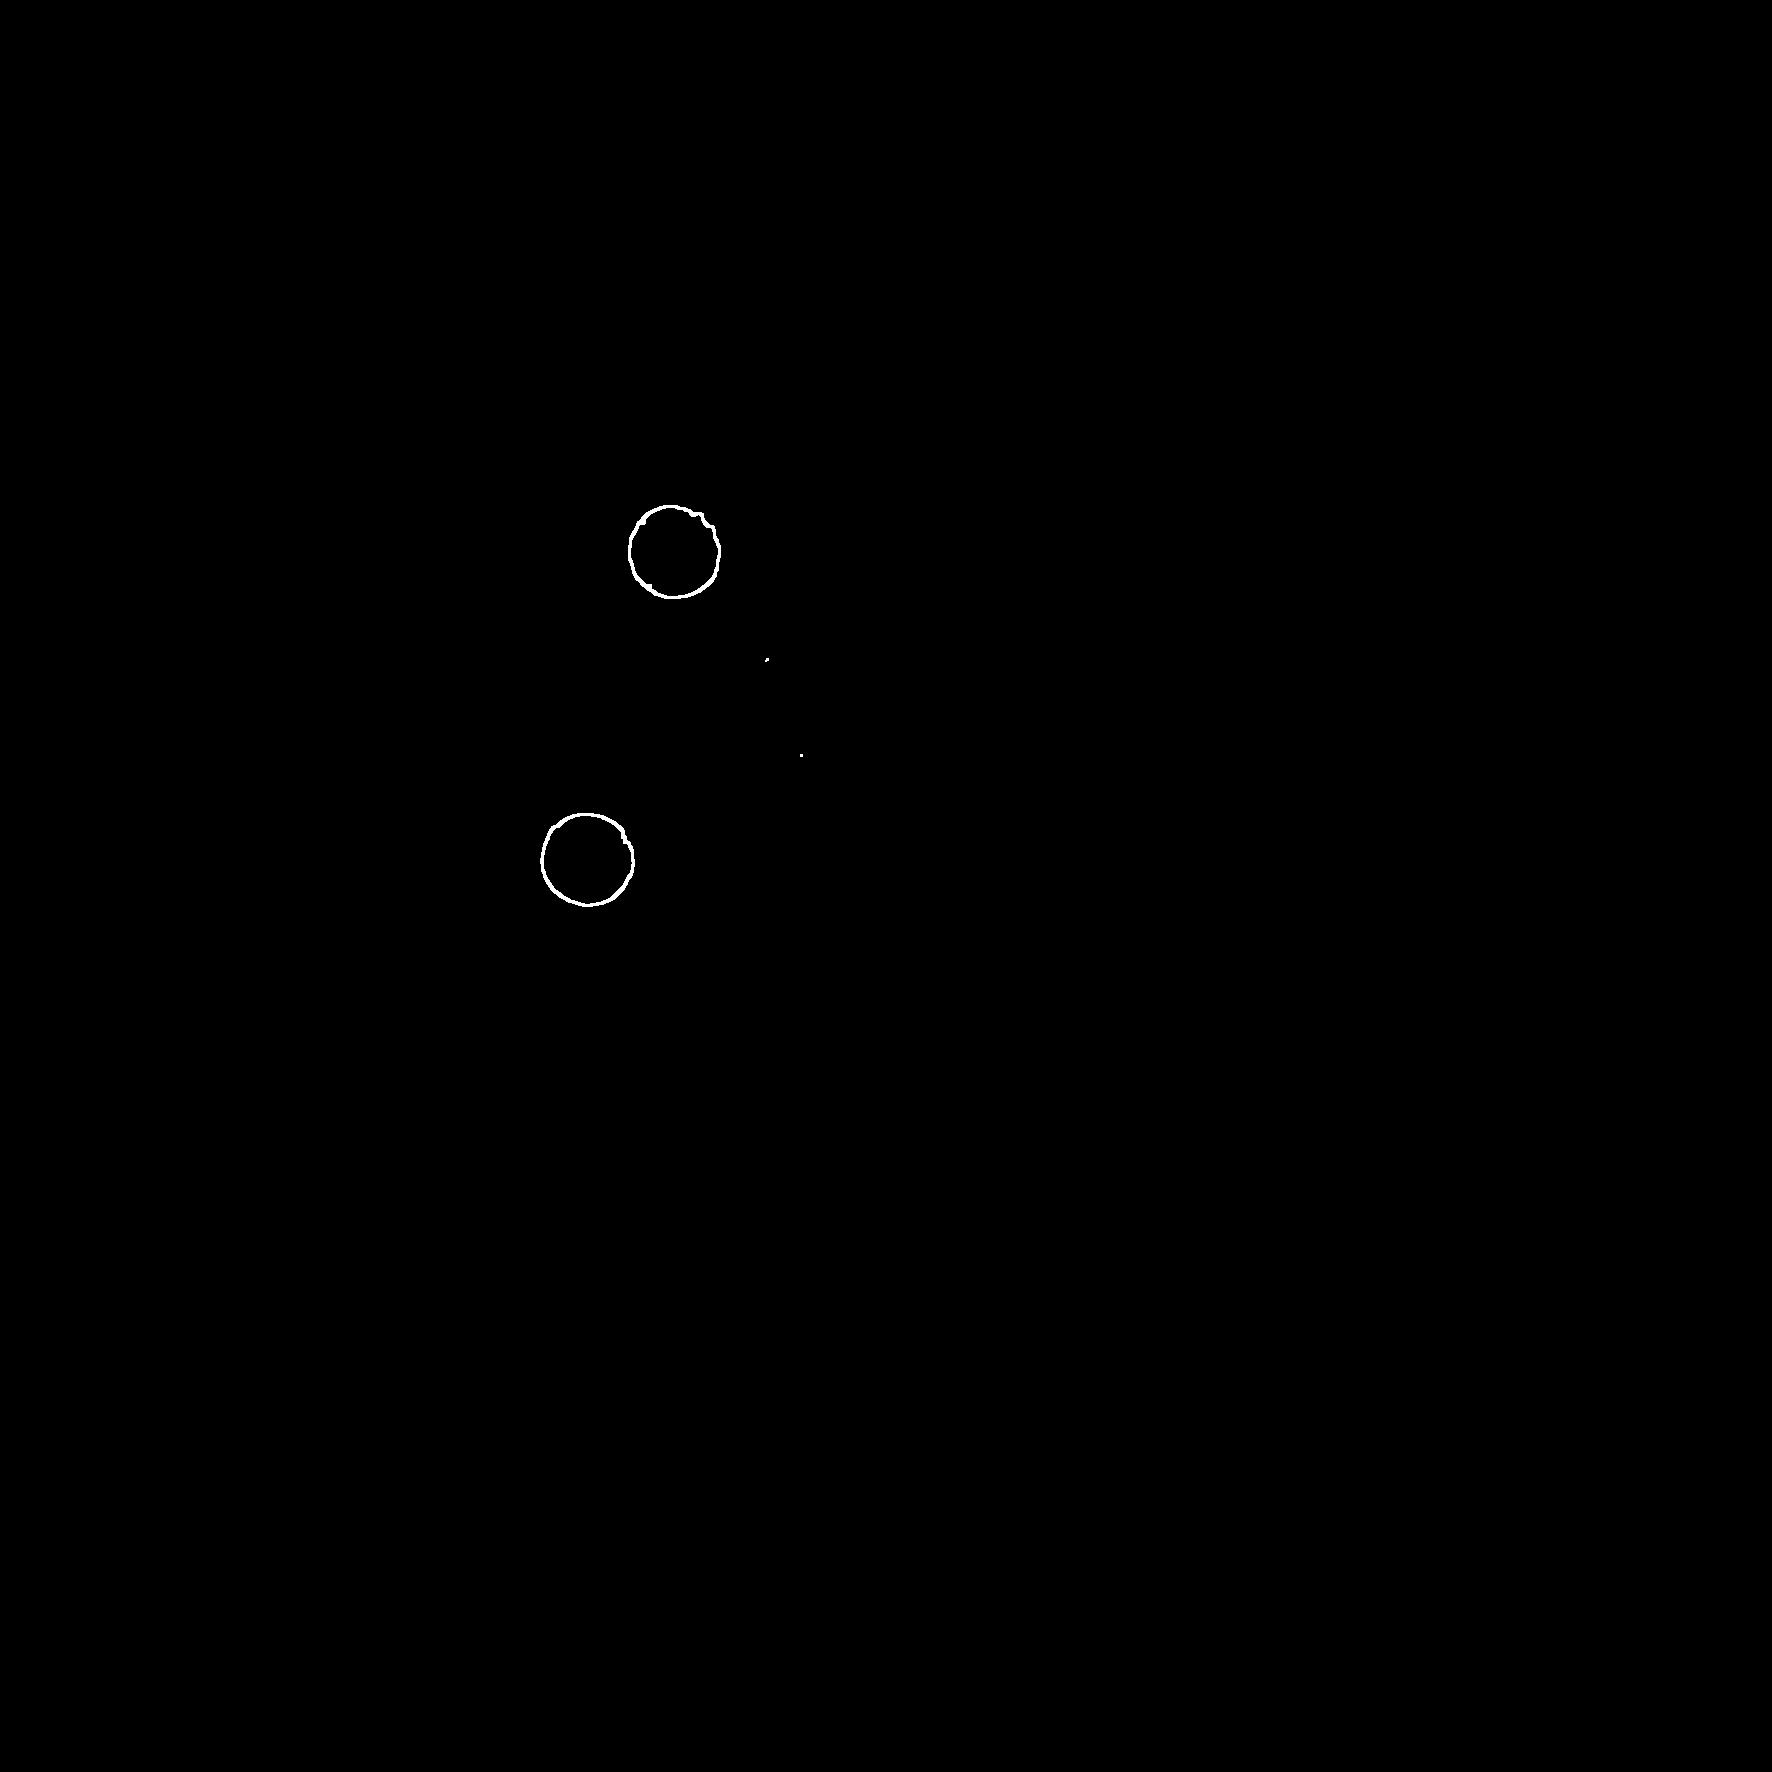

dots:  0


In [ ]:
test_path = '/content/extracted_images/processed_images/test'

# Utwórz folder processed_images, jeśli nie istnieje
os.makedirs(test_path, exist_ok=True)

image_files = os.listdir(test_path)

for image_file in image_files:
    image_path = os.path.join(test_path, image_file)
    image = cv2.imread(image_path)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    cv2_imshow(image)

    # Znalezienie konturów w obrazie
    cnt, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Rysowanie konturów
    cv2.drawContours(image, cnt, -1, (0, 255, 0), 2)

    # Zliczenie czarnych kropek na podstawie pola powierzchni i kolistości
    black_dot_count = 0
    for contour in cnt:
        area = cv2.contourArea(contour)
        if area < 100:  # Minimalna wielkość obszaru, aby uznać go za czarną kropkę
            continue

        # Sprawdzenie, czy kontur jest zbliżony do kształtu okręgu
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > 0.8:  # Określ próg, powyżej którego uznajemy kształt za okrągły
            black_dot_count += 1

    print("dots: ", black_dot_count)

Proces przetwarzania obrazów:
1. Ładowanie obrazu
2. Konwersja do skali szarości
3. Rozmycie Gaussowskie
4. Binaryzacja obrazu
5. Detekcja krawędzi
6. Dylatacja
7. Znalezenie konturów
7. Klasyfikacja konturów na podstawie obszaru i kolistości

Co dalej?
1. Stworzyć nowy dataset z różnorodnym tłem - 100 zdjęć na klasę
2. Użyć 2-3% zbioru na klasyfikację wykorzystującą APO.
	- podzielić dane na zbiór treningowy/testowy (chyba najprościej)
	- pomieszać dane przed podziałem
	- wykonać klasyfikację
	- sprawdzić dokładność ręcznie lub jak jest czas zautomatyzować to.
3. Użyć 100% zbioru do treningu i klasyfikacji wykorzystującą ML.
